# Make depth summary figures

This notebook is to produce some figures for the ELAIS-N1 paper.

First we will, for every helpix 13 in HELP get the highest K or Ks depth, g depth, and irac 1 depth. We will then plot cumulative area histograms and generate the 25%, 50%, 75% areas to summarise the depths across all HELP.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))


This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)


In [2]:
import pyvo as vo
import glob
import time
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import random

import herschelhelp as hh
from herschelhelp_internal.utils import flux_to_mag

from astropy.table import Table, Column, vstack, join, unique

from pymoc import MOC

import pandas as pd

import yaml

from pcigale.sed import SED
from pcigale.sed_modules import get_module

In [72]:

#Then we establish the VO connection to our database
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")

In [4]:
herschelhelp_python_loc = ('../../../../herschelhelp_python/')

filter_locs  = glob.glob(herschelhelp_python_loc + 'database_builder/filters/*')

In [5]:
filters = [f.split('/')[-1].split('.')[0] for f in filter_locs]
try:
    filters.remove('readme')
except ValueError:
    print('no readme')

bands = ['u', 'g', 'r', 'i', 'z', 'y',
        'J', 'H', 'K', 'Ks',
        'i1', 'i2', 'i3', 'i4']

no readme


In [6]:
filters

['wfi_696nm',
 'suprime_nb816',
 'wfc3_f125w',
 'mmt_g',
 'omegacam_r',
 'decam_z',
 'wfi_416nm',
 'sdss_i',
 'omegacam_g',
 'suprime_ib464',
 'wfi_571nm',
 'mmt_r',
 'wfc3_f105w',
 'spire_350',
 'decam_y',
 'suprime_ib505',
 'cfht12k_b',
 '90prime_z',
 'omegacam_u',
 'suprime_ip',
 'isaac_k',
 'galex_nuv',
 'acs_f775w',
 'moircs_k',
 'sdss_z',
 'acs_f606w',
 'cfht12k_r',
 'decam_i',
 'quirc_hk',
 'mmt_u',
 'suprime_zpp',
 'suprime_ia624',
 'megacam_r',
 'bessell_v',
 'wircam_ks',
 'mips_24',
 'omega2000_j',
 'wfi_r',
 'spire_250',
 'suprime_r',
 'gpc1_i',
 'suprime_g',
 'bessell_b',
 'bessell_u',
 'mosaic_r',
 'wfi_753nm',
 'acs_f850lp',
 'ukidss_y',
 'megacam_g',
 'wfc_z',
 'lbc_u',
 'suprime_ia527',
 'wfc_i',
 'wfi_b123',
 'gpc1_y',
 'suprime_b',
 'wfi_b',
 'wfi_u',
 'suprime_ia679',
 'ukidss_j',
 'suprime_ib827',
 'suprime_ia484',
 'ukidss_k',
 'megacam_u',
 'newfirm_j1',
 'suprime_n816',
 'gpc1_z',
 'newfirm_j3',
 'suprime_v',
 'wfi_v',
 'mosaic_b',
 'mosaic_u',
 'ukidss_h',
 'bes

In [7]:
irac_i1_query="""
SELECT DISTINCT hp_idx_O_10, ferr_ap_irac_i1_mean
FROM depth.main
WHERE ferr_ap_irac_i1_mean IS NOT NULL
"""

#Then we execute the query
#resultset = service.run_async(irac_i1_query)
job = service.submit_job(irac_i1_query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
while job.phase == 'EXECUTING':
    print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(10) #wait ten seconds and try again
    
table = job_result.fetch_result() 
i1_table = table.table

Job still running after 0 seconds.


In [8]:
i1_table

hp_idx_o_10,ferr_ap_irac_i1_mean
,uJy
int64,float64
1547506,1.43366666666667
1547507,1.52794117647059
1547510,1.66105263157895
1547511,1.94072727272727
1547512,1.62485294117647
1547513,1.03740540540541
1547514,1.42491329479769
1547515,0.732934782608696


(array([1.8694e+04, 3.2534e+04, 3.2980e+03, 1.0970e+03, 1.2085e+04,
        1.4502e+04, 1.0610e+03, 3.7000e+01, 2.0000e+00, 3.0000e+00]),
 array([-0.49291727, -0.01875222,  0.45541283,  0.92957788,  1.40374293,
         1.87790798,  2.35207303,  2.82623808,  3.30040313,  3.77456818,
         4.24873323]),
 <a list of 10 Patch objects>)

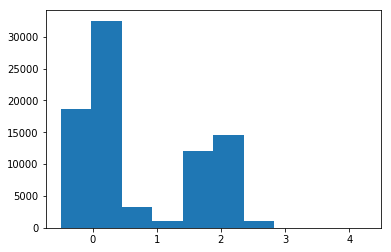

In [9]:
plt.hist(np.log10(i1_table['ferr_ap_irac_i1_mean']) )

In [10]:
irac_i1_moc = MOC(10, i1_table['hp_idx_o_10'])
irac_i1_moc.area_sq_deg
total_area = irac_i1_moc.area_sq_deg
total_area

273.1409041542108

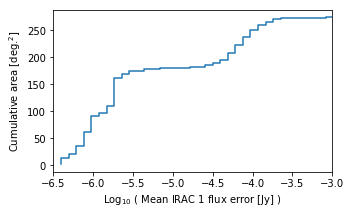

In [11]:
fig, ax = plt.subplots()

cells, fluxes = np.histogram(np.log10(i1_table['ferr_ap_irac_i1_mean']*1.e-6), bins=50)
ax.plot(fluxes[1:],
         np.cumsum(cells)*total_area/cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('Log$_{10}$ ( Mean IRAC 1 flux error [Jy] )')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([-6.5,-3.0])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.4 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.tight_layout()
plt.savefig('./figs/IRAC_i1_cumulative_area_depth.pdf')
plt.savefig('./figs/IRAC_i1_cumulative_area_depth.png')

In [12]:
i1_p25, i1_p50, i1_p75 = np.nanpercentile(i1_table['ferr_ap_irac_i1_mean'] * 3.,[25, 50, 75])
"""
The IRAC i1 band has coverage over {} square degrees with  3 sigma 
depths at the 25th, 50th and 75th percentiles of {}, {}, {} respectively.""".format(total_area, i1_p25, i1_p50, i1_p75)

'\nThe IRAC i1 band has coverage over 273.1409041542108 square degrees with  3 sigma \ndepths at the 25th, 50th and 75th percentiles of 2.955037033451454, 5.86515255980631, 176.669196 respectively.'

In mags as per reviewer request

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


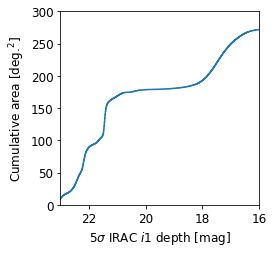

In [13]:
fig, ax = plt.subplots()

i1_pix_mag_depths, _ = flux_to_mag(i1_table['ferr_ap_irac_i1_mean']*1.e-6*5)
cells, fluxes = np.histogram(i1_pix_mag_depths, bins=1000)
#We want cumulative from faint to bright
cells =np.flip(cells)
fluxes = np.flip(fluxes)
ax.plot(fluxes[1:],
         np.cumsum(cells)*total_area/cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('5$\sigma$ IRAC $i1$ depth [mag]')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([23,16])
ax.set_ylim([0,300])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)



plt.savefig('./figs/IRAC_i1_cumulative_area_depth_mag.pdf', bbox_inches='tight')
plt.savefig('./figs/IRAC_i1_cumulative_area_depth_mag.png', bbox_inches='tight')

In [14]:
mi1_p25, mi1_p50, mi1_p75 = np.nanpercentile(i1_pix_mag_depths ,[25, 50, 75])
"""
The IRAC i1 band has coverage over {} square degrees with  5 sigma 
depths at the 25th, 50th and 75th percentiles of {}, {}, {} respectively.""".format(total_area, mi1_p25, mi1_p50, mi1_p75)

'\nThe IRAC i1 band has coverage over 273.1409041542108 square degrees with  5 sigma \ndepths at the 25th, 50th and 75th percentiles of 17.727476044402813, 21.424679843133582, 22.16897080604381 respectively.'

## g bands

There are multiple g type bands so we the the maximum depth of all of them.

In [15]:
g_filters = [f for f in filters if f.split('_')[1] == 'g']
spaced_list = ''
for g in g_filters:
    spaced_list = spaced_list + ', ferr_ap_' + g + '_mean'
print(spaced_list)

, ferr_ap_mmt_g_mean, ferr_ap_omegacam_g_mean, ferr_ap_suprime_g_mean, ferr_ap_megacam_g_mean, ferr_ap_wfc_g_mean, ferr_ap_gpc1_g_mean, ferr_ap_decam_g_mean, ferr_ap_90prime_g_mean, ferr_ap_sdss_g_mean


In [16]:
g_bands_query="""
SELECT DISTINCT hp_idx_O_10{}
FROM depth.main

""".format(spaced_list)
g_bands_query

'\nSELECT DISTINCT hp_idx_O_10, ferr_ap_mmt_g_mean, ferr_ap_omegacam_g_mean, ferr_ap_suprime_g_mean, ferr_ap_megacam_g_mean, ferr_ap_wfc_g_mean, ferr_ap_gpc1_g_mean, ferr_ap_decam_g_mean, ferr_ap_90prime_g_mean, ferr_ap_sdss_g_mean\nFROM depth.main\n\n'

In [17]:
#Then we execute the query
#resultset = service.run_async(irac_i1_query)
job = service.submit_job(g_bands_query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
while job.phase == 'EXECUTING':
    print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(10) #wait ten seconds and try again
    
print(job.phase)
table = job_result.fetch_result() 




Job still running after 0 seconds.
Job still running after 10 seconds.
Job still running after 20 seconds.
Job still running after 31 seconds.
Job still running after 41 seconds.
COMPLETED


In [18]:
g_depth_cols  = ["ferr_ap_{}_mean".format(band) for band in g_filters]
g_depth_cols

['ferr_ap_mmt_g_mean',
 'ferr_ap_omegacam_g_mean',
 'ferr_ap_suprime_g_mean',
 'ferr_ap_megacam_g_mean',
 'ferr_ap_wfc_g_mean',
 'ferr_ap_gpc1_g_mean',
 'ferr_ap_decam_g_mean',
 'ferr_ap_90prime_g_mean',
 'ferr_ap_sdss_g_mean']

In [19]:
g_table = Table(table.table)
for col in g_depth_cols:
    g_table[col].fill_value = np.nan
g_table = g_table.filled()

In [20]:
np.nanmin([g_table[column] for column in g_depth_cols], axis=0)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: All-NaN axis encountered
  if __name__ == '__main__':


array([2.07127300e-07, 2.18198880e-07, 1.93754770e-07, ...,
       6.84728411e-01, 4.62498951e-01, 5.92936370e-01])

In [21]:
for col in g_depth_cols:
    print(col, np.sum(np.log10(np.array(g_table[col])*1.e-6) < -9))

ferr_ap_mmt_g_mean 0
ferr_ap_omegacam_g_mean 0
ferr_ap_suprime_g_mean 0
ferr_ap_megacam_g_mean 4
ferr_ap_wfc_g_mean 0
ferr_ap_gpc1_g_mean 2
ferr_ap_decam_g_mean 42483
ferr_ap_90prime_g_mean 9564
ferr_ap_sdss_g_mean 0


/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [22]:
decam_low = (np.log10(np.array(g_table['ferr_ap_decam_g_mean'])*1.e-6) < -9)
prime_low = (np.log10(np.array(g_table['ferr_ap_90prime_g_mean'])*1.e-6) < -9)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [23]:
decam_bad_moc = MOC(10, g_table['hp_idx_o_10'][decam_low])
prime_bad_moc = MOC(10, g_table['hp_idx_o_10'][decam_low])

fields = yaml.load(open('../../../dmu2/meta_main.yml', 'r'))


for field in fields['fields']:
    field_moc = MOC(filename=field['region'].replace('dmu_products/', '../../../'))
    decam_bad_area = decam_bad_moc.intersection(field_moc).area_sq_deg
    prime_bad_area = prime_bad_moc.intersection(field_moc).area_sq_deg
    print("{} has {} sq deg of bad DECam and {} sq degrees of bad 90Prime".format(field['name'], 
                                                                                  decam_bad_area, 
                                                                                  prime_bad_area))

AKARI-NEP has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
AKARI-SEP has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
Bootes has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
CDFS-SWIRE has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
COSMOS has 4.993602528615098 sq deg of bad DECam and 4.993602528615098 sq degrees of bad 90Prime
EGS has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
ELAIS-N1 has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
ELAIS-N2 has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
ELAIS-S1 has 0.0 sq deg of bad DECam and 0.0 sq degrees of bad 90Prime
GAMA-09 has 58.83676922758017 sq deg of bad DECam and 58.83676922758017 sq degrees of bad 90Prime
GAMA-12 has 41.50292732171963 sq deg of bad DECam and 41.50292732171963 sq degrees of bad 90Prime
GAMA-15 has 24.055567671853485 sq deg of bad DECam and 24.055567671853485 sq degrees of bad 90Prime
HDF-N has 0.0 sq deg of bad DECam and 0.0 

In [24]:
g_table['ferr_ap_decam_g_mean'][decam_low] = g_table['ferr_ap_decam_g_mean'][decam_low] * 1.e6
g_table['ferr_ap_90prime_g_mean'][prime_low] = g_table['ferr_ap_90prime_g_mean'][prime_low] * 1.e6

In [25]:
g_table.add_column(Column(data=np.nanmin([g_table[column] for column in g_depth_cols], axis=0), name='ferr_g_min'))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: All-NaN axis encountered
  if __name__ == '__main__':


In [26]:
g_table['hp_idx_o_10', 'ferr_g_min']

hp_idx_o_10,ferr_g_min
int64,float64
1048576,0.01926224
1048577,0.020717567
1048578,0.021378249
1048579,0.021092668
1048580,0.020199573
1048581,0.022394473
1048582,0.020951325
1048583,0.020383537
1048584,0.022677435


In [27]:
g_moc = MOC(10, g_table['hp_idx_o_10'])
g_moc.area_sq_deg
total_area_g = g_moc.area_sq_deg
total_area_g

1292.6302392940547

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


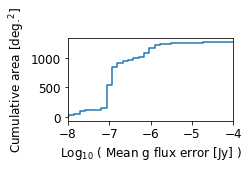

In [28]:
g_table['hp_idx_o_10', 'ferr_g_min']

fig, ax = plt.subplots()

good = np.log10(np.array(g_table['ferr_g_min'])*1.e-6) > -20
good &= np.log10(np.array(g_table['ferr_g_min'])*1.e-6) <20

cells, fluxes = np.histogram(np.log10(np.array(g_table['ferr_g_min'][good ])*1.e-6), bins=100)
ax.plot(fluxes[1:],
         np.cumsum(cells)*1270./cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('Log$_{10}$ ( Mean g flux error [Jy] )')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([-8,-4.0])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])



plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.tight_layout()
plt.savefig('./figs/g_cumulative_area_depth.pdf')
plt.savefig('./figs/g_cumulative_area_depth.png')

In [29]:
g_p25, g_p50, g_p75 = np.nanpercentile(g_table['ferr_g_min'][good ] * 3.,[25, 50, 75])
"""
The g band has coverage over {} square degrees with  3 sigma 
depths at the 25th, 50th and 75th percentiles of {}, {}, {} respectively.""".format(1270, g_p25, g_p50, g_p75)

'\nThe g band has coverage over 1270 square degrees with  3 sigma \ndepths at the 25th, 50th and 75th percentiles of 0.30178651661213773, 0.367626929893692, 0.8854647236256772 respectively.'

In mags as per reviewer request

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


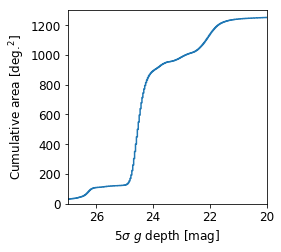

In [30]:
g_table['hp_idx_o_10', 'ferr_g_min']

fig, ax = plt.subplots()

good = np.log10(np.array(g_table['ferr_g_min'])*1.e-6) > -20
good &= np.log10(np.array(g_table['ferr_g_min'])*1.e-6) <20

g_pix_mag_depths, _ = flux_to_mag(np.array(g_table['ferr_g_min'][good ])*1.e-6*5)
cells, fluxes = np.histogram(g_pix_mag_depths, bins=1000)
cells =np.flip(cells)
fluxes = np.flip(fluxes)

ax.plot(fluxes[1:],
         np.cumsum(cells)*1270./cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('5$\sigma$ $g$ depth [mag] ')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([27,20])
ax.set_ylim([0,1300])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])



plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/g_cumulative_area_depth_mag.pdf', bbox_inches='tight')
plt.savefig('./figs/g_cumulative_area_depth_mag.png', bbox_inches='tight')

In [31]:
mg_p25, mg_p50, mg_p75 = np.nanpercentile(g_pix_mag_depths,[25, 50, 75])
"""
The g band has coverage over {} square degrees with  3 sigma 
depths at the 25th, 50th and 75th percentiles of {}, {}, {} respectively.""".format(1270, mg_p25, mg_p50, mg_p75)

'\nThe g band has coverage over 1270 square degrees with  3 sigma \ndepths at the 25th, 50th and 75th percentiles of 23.47744996638206, 24.43185983247774, 24.646128545411877 respectively.'

In [32]:
g_table[prime_low]

hp_idx_o_10,ferr_ap_mmt_g_mean,ferr_ap_omegacam_g_mean,ferr_ap_suprime_g_mean,ferr_ap_megacam_g_mean,ferr_ap_wfc_g_mean,ferr_ap_gpc1_g_mean,ferr_ap_decam_g_mean,ferr_ap_90prime_g_mean,ferr_ap_sdss_g_mean,ferr_g_min
,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2652662,nan,nan,nan,nan,nan,0.987825059481603,nan,0.20031881999999998,nan,0.20031881999999998
2652663,nan,nan,nan,nan,nan,42.3153061976883,nan,0.1769414,nan,0.1769414
2652667,nan,nan,nan,nan,nan,0.777482608504748,nan,0.200318,nan,0.200318
2652668,nan,nan,nan,nan,nan,1.21649049703478,nan,0.20031815,nan,0.20031815
2652669,nan,nan,nan,nan,nan,26.3897794278116,nan,0.18906452,nan,0.18906452
2652670,nan,nan,nan,nan,nan,0.909743596951121,nan,0.2003182,nan,0.2003182
2652671,nan,nan,nan,nan,nan,0.907613326799461,nan,0.20031814,nan,0.20031814
2652983,nan,nan,nan,nan,nan,0.759221342327773,nan,0.19815181,nan,0.19815181


## K or Ks filters
the same for K

In [33]:
K_filters = [f for f in filters if f.split('_')[1].startswith('k')]
K_filters

['isaac_k',
 'moircs_k',
 'wircam_ks',
 'ukidss_k',
 'vista_ks',
 'moircs_ks',
 'newfirm_k',
 'omega2000_ks',
 'tifkam_ks',
 'wircs_k',
 'hawki_k']

In [34]:

spaced_list = ''
for K in K_filters:
    spaced_list = spaced_list + ', ferr_ap_' + K + '_mean'
print(spaced_list)

, ferr_ap_isaac_k_mean, ferr_ap_moircs_k_mean, ferr_ap_wircam_ks_mean, ferr_ap_ukidss_k_mean, ferr_ap_vista_ks_mean, ferr_ap_moircs_ks_mean, ferr_ap_newfirm_k_mean, ferr_ap_omega2000_ks_mean, ferr_ap_tifkam_ks_mean, ferr_ap_wircs_k_mean, ferr_ap_hawki_k_mean


In [35]:
K_bands_query="""
SELECT DISTINCT hp_idx_O_10{}
FROM depth.main

""".format(spaced_list)
K_bands_query

'\nSELECT DISTINCT hp_idx_O_10, ferr_ap_isaac_k_mean, ferr_ap_moircs_k_mean, ferr_ap_wircam_ks_mean, ferr_ap_ukidss_k_mean, ferr_ap_vista_ks_mean, ferr_ap_moircs_ks_mean, ferr_ap_newfirm_k_mean, ferr_ap_omega2000_ks_mean, ferr_ap_tifkam_ks_mean, ferr_ap_wircs_k_mean, ferr_ap_hawki_k_mean\nFROM depth.main\n\n'

In [36]:
#Then we execute the query
#resultset = service.run_async(irac_i1_query)
job = service.submit_job(K_bands_query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
while job.phase == 'EXECUTING':
    print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(10) #wait ten seconds and try again
    
print(job.phase)
table = job_result.fetch_result() 

Job still running after 0 seconds.
Job still running after 10 seconds.
Job still running after 20 seconds.
Job still running after 31 seconds.
Job still running after 41 seconds.
COMPLETED


In [37]:
depth_cols  = ["ferr_ap_{}_mean".format(band) for band in K_filters]
depth_cols

['ferr_ap_isaac_k_mean',
 'ferr_ap_moircs_k_mean',
 'ferr_ap_wircam_ks_mean',
 'ferr_ap_ukidss_k_mean',
 'ferr_ap_vista_ks_mean',
 'ferr_ap_moircs_ks_mean',
 'ferr_ap_newfirm_k_mean',
 'ferr_ap_omega2000_ks_mean',
 'ferr_ap_tifkam_ks_mean',
 'ferr_ap_wircs_k_mean',
 'ferr_ap_hawki_k_mean']

In [38]:
K_table = Table(table.table)
for col in depth_cols:
    K_table[col].fill_value = np.nan
K_table = K_table.filled()

In [39]:
len(K_table)

394298

In [40]:
K_table.add_column(Column(data=np.nanmin([K_table[column] for column in depth_cols], axis=0), name='ferr_K_min'))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: All-NaN axis encountered
  if __name__ == '__main__':


In [41]:
np.sum(np.isnan(K_table['ferr_K_min'] ))

44649

In [42]:
K_moc = MOC(10, K_table[~np.isnan(K_table['ferr_K_min'] )]['hp_idx_o_10'])
K_moc.area_sq_deg
total_area_K = K_moc.area_sq_deg
total_area_K

1146.2587389655478

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


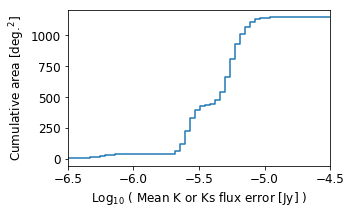

In [43]:
K_table['hp_idx_o_10', 'ferr_K_min']

fig, ax = plt.subplots()

good = np.log10(np.array(K_table['ferr_K_min'])*1.e-6) > -20
good &= np.log10(np.array(K_table['ferr_K_min'])*1.e-6) <20

cells, fluxes = np.histogram(np.log10(np.array(K_table['ferr_K_min'][good ])*1.e-6), bins=100)
ax.plot(fluxes[1:],
         np.cumsum(cells)*total_area_K/cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('Log$_{10}$ ( Mean K or Ks flux error [Jy] )')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([-6.5,-4.5])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.4 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.tight_layout()

plt.savefig('./figs/K_cumulative_area_depth.pdf')
plt.savefig('./figs/K_cumulative_area_depth.png')

In [44]:
K_p25, K_p50, K_p75 = np.nanpercentile(K_table['ferr_K_min'][good ] * 3.,[25, 50, 75])
"""
The K band has coverage over {} square degrees with  3 sigma 
depths at the 25th, 50th and 75th percentiles of {}, {}, {} respectively.""".format(total_area_K, K_p25, K_p50, K_p75)

'\nThe K band has coverage over 1146.2587389655478 square degrees with  3 sigma \ndepths at the 25th, 50th and 75th percentiles of 8.507107317226373, 15.31927155, 18.434229287923927 respectively.'

And in mags as per reviewer request

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


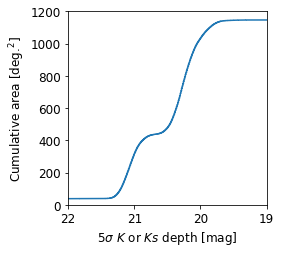

In [45]:
K_table['hp_idx_o_10', 'ferr_K_min']

fig, ax = plt.subplots()

good = np.log10(np.array(K_table['ferr_K_min'])*1.e-6) > -20
good &= np.log10(np.array(K_table['ferr_K_min'])*1.e-6) <20

#cells, fluxes = np.histogram(np.log10(np.array(K_table['ferr_K_min'][good ])*1.e-6), bins=100)

K_pix_mag_depths, _ = flux_to_mag(np.array(K_table['ferr_K_min'][good ])*1.e-6*5)
cells, fluxes = np.histogram(K_pix_mag_depths, bins=1000)
cells =np.flip(cells)
fluxes = np.flip(fluxes)



ax.plot(fluxes[1:],
         np.cumsum(cells)*total_area_K/cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('5$\sigma$ $K$ or $Ks$ depth [mag]')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([22,19])
ax.set_ylim([0,1200])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/K_cumulative_area_depth_mag.pdf', bbox_inches='tight')
plt.savefig('./figs/K_cumulative_area_depth_mag.png', bbox_inches='tight')

In [46]:
K_p25, K_p50, K_p75 = np.nanpercentile(K_pix_mag_depths,[25, 50, 75])
("The K or Ks band has coverage over {} square degrees with  5 sigma"  +
"depths at the 25th, 50th and 75th percentiles of {}, {}, {} respectively.").format(total_area_K, K_p25, K_p50, K_p75)

'The K or Ks band has coverage over 1146.2587389655478 square degrees with  5 sigmadepths at the 25th, 50th and 75th percentiles of 20.181315663428137, 20.38228283956797, 21.020923347289685 respectively.'

## Make a table of bands available on each field

In [47]:
bands = ['u', 'g', 'r', 'i', 'z', 'y',
        'J', 'H', 'K', 'Ks',
        'i1', 'i2', 'i3', 'i4']

In [48]:
spaced_list = ''
for m, band in enumerate(bands):
    specific_bands = [f for f in filters if f.split('_')[1] == band.lower()]
    for specific_band in specific_bands:
        spaced_list = spaced_list + ', ferr_ap_' + specific_band + '_mean'
        
spaced_list = spaced_list.replace(' ferr_ap_lbc_u_mean,', '')
spaced_list = spaced_list.replace(' ferr_ap_lbc_y_mean,', '')

In [49]:
spaced_list

', ferr_ap_omegacam_u_mean, ferr_ap_mmt_u_mean, ferr_ap_bessell_u_mean, ferr_ap_wfi_u_mean, ferr_ap_megacam_u_mean, ferr_ap_mosaic_u_mean, ferr_ap_wfc_u_mean, ferr_ap_sdss_u_mean, ferr_ap_mmt_g_mean, ferr_ap_omegacam_g_mean, ferr_ap_suprime_g_mean, ferr_ap_megacam_g_mean, ferr_ap_wfc_g_mean, ferr_ap_gpc1_g_mean, ferr_ap_decam_g_mean, ferr_ap_90prime_g_mean, ferr_ap_sdss_g_mean, ferr_ap_omegacam_r_mean, ferr_ap_mmt_r_mean, ferr_ap_cfht12k_r_mean, ferr_ap_megacam_r_mean, ferr_ap_wfi_r_mean, ferr_ap_suprime_r_mean, ferr_ap_mosaic_r_mean, ferr_ap_bessell_r_mean, ferr_ap_wfc_r_mean, ferr_ap_gpc1_r_mean, ferr_ap_decam_r_mean, ferr_ap_sdss_r_mean, ferr_ap_90prime_r_mean, ferr_ap_sdss_i_mean, ferr_ap_decam_i_mean, ferr_ap_gpc1_i_mean, ferr_ap_wfc_i_mean, ferr_ap_bessell_i_mean, ferr_ap_mosaic_i_mean, ferr_ap_megacam_i_mean, ferr_ap_wfi_i_mean, ferr_ap_suprime_i_mean, ferr_ap_cfht12k_i_mean, ferr_ap_mmt_i_mean, ferr_ap_omegacam_i_mean, ferr_ap_decam_z_mean, ferr_ap_90prime_z_mean, ferr_ap_sdss_

In [50]:

query = """
SELECT DISTINCT hp_idx_O_10{}
FROM depth.main
""".format(spaced_list)
job = service.submit_job(query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
print(time.time())
while job.phase == 'EXECUTING':
    print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(50) #wait ten seconds and try again
    
print(job.phase)
print('Fetching result', time.time())
table = job_result.fetch_result()

1576062295.95764
Job still running after 0 seconds.
Job still running after 50 seconds.
Job still running after 100 seconds.
Job still running after 151 seconds.
Job still running after 201 seconds.


COMPLETED
Fetching result 1576062547.0170062


In [51]:
depth_table = table.table
depth_table 

hp_idx_o_10,ferr_ap_omegacam_u_mean,ferr_ap_mmt_u_mean,ferr_ap_bessell_u_mean,ferr_ap_wfi_u_mean,ferr_ap_megacam_u_mean,ferr_ap_mosaic_u_mean,ferr_ap_wfc_u_mean,ferr_ap_sdss_u_mean,ferr_ap_mmt_g_mean,ferr_ap_omegacam_g_mean,ferr_ap_suprime_g_mean,ferr_ap_megacam_g_mean,ferr_ap_wfc_g_mean,ferr_ap_gpc1_g_mean,ferr_ap_decam_g_mean,ferr_ap_90prime_g_mean,ferr_ap_sdss_g_mean,ferr_ap_omegacam_r_mean,ferr_ap_mmt_r_mean,ferr_ap_cfht12k_r_mean,ferr_ap_megacam_r_mean,ferr_ap_wfi_r_mean,ferr_ap_suprime_r_mean,ferr_ap_mosaic_r_mean,ferr_ap_bessell_r_mean,ferr_ap_wfc_r_mean,ferr_ap_gpc1_r_mean,ferr_ap_decam_r_mean,ferr_ap_sdss_r_mean,ferr_ap_90prime_r_mean,ferr_ap_sdss_i_mean,ferr_ap_decam_i_mean,ferr_ap_gpc1_i_mean,ferr_ap_wfc_i_mean,ferr_ap_bessell_i_mean,ferr_ap_mosaic_i_mean,ferr_ap_megacam_i_mean,ferr_ap_wfi_i_mean,ferr_ap_suprime_i_mean,ferr_ap_cfht12k_i_mean,ferr_ap_mmt_i_mean,ferr_ap_omegacam_i_mean,ferr_ap_decam_z_mean,ferr_ap_90prime_z_mean,ferr_ap_sdss_z_mean,ferr_ap_wfc_z_mean,ferr_ap_gpc1_z_mean,ferr_ap_suprime_z_mean,ferr_ap_megacam_z_mean,ferr_ap_vista_z_mean,ferr_ap_mosaic_z_mean,ferr_ap_omegacam_z_mean,ferr_ap_mmt_z_mean,ferr_ap_decam_y_mean,ferr_ap_ukidss_y_mean,ferr_ap_gpc1_y_mean,ferr_ap_suprime_y_mean,ferr_ap_megacam_y_mean,ferr_ap_vista_y_mean,ferr_ap_wircam_y_mean,ferr_ap_omega2000_j_mean,ferr_ap_ukidss_j_mean,ferr_ap_vista_j_mean,ferr_ap_newfirm_j_mean,ferr_ap_wircs_j_mean,ferr_ap_wircam_j_mean,ferr_ap_ukidss_h_mean,ferr_ap_vista_h_mean,ferr_ap_newfirm_h_mean,ferr_ap_wircam_h_mean,ferr_ap_isaac_k_mean,ferr_ap_moircs_k_mean,ferr_ap_ukidss_k_mean,ferr_ap_newfirm_k_mean,ferr_ap_wircs_k_mean,ferr_ap_hawki_k_mean,ferr_ap_wircam_ks_mean,ferr_ap_vista_ks_mean,ferr_ap_moircs_ks_mean,ferr_ap_omega2000_ks_mean,ferr_ap_tifkam_ks_mean,ferr_ap_irac_i1_mean,ferr_ap_irac_i2_mean,ferr_ap_irac_i3_mean,ferr_ap_irac_i4_mean
,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1048576,0.3888968,--,--,--,--,--,--,--,--,0.10194926,0.01926224,--,--,0.91465111996888,2.071273e-07,--,--,0.13300735,--,--,--,--,0.030870374,--,--,--,2.42656648971231,3.1425782e-07,--,--,--,--,2.17693319900341,--,--,--,--,--,0.041768204,--,--,0.23194352,2.2510854e-07,--,--,--,146.925748841671,0.06151843,--,0.46263823,--,--,--,--,3.2966712,68.0845813961089,0.14352015,--,--,--,--,4.862965,1.92945241928101,--,--,--,4.8178754,1.7355504155159,--,--,--,--,6.3801355,--,--,--,--,2.36790292603629,--,--,--,--,--,--,--
1048577,0.3287,--,--,--,--,--,--,--,--,0.097032174,0.020717567,--,--,1.94901887644096,2.1819888e-07,--,--,0.117325865,--,--,--,--,0.03293594,--,--,--,2.40327171228006,3.3950195e-07,--,--,--,--,2.99968585945623,--,--,--,--,--,0.044771805,--,--,0.20181328,2.5253004e-07,--,--,--,5.5478680208702,0.06634453,--,0.46295264,--,--,--,--,4.16338,6.02002735205644,0.1526159,--,--,--,--,5.2789373,1.91976457834244,--,--,--,5.391274,1.66691474914551,--,--,--,--,6.573922,--,--,--,--,2.3642338684627,--,--,--,--,--,--,--
1048578,0.3846171,--,--,--,--,--,--,--,--,0.08947918,0.021378249,--,--,14.2197571078478,1.9375477e-07,

In [52]:
cosmos_coverage = Table.read('../../../dmu1/dmu1_ml_COSMOS/data/depths_cosmos_20190402.fits')

In [53]:
cosmos_coverage[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10,ferr_ap_vista_ks_mean,f_ap_vista_ks_p90,ferr_vista_ks_mean,f_vista_ks_p90,ferr_ap_vista_y_mean,f_ap_vista_y_p90,ferr_vista_y_mean,f_vista_y_p90,ferr_ap_vista_h_mean,f_ap_vista_h_p90,ferr_vista_h_mean,f_vista_h_p90,ferr_ap_vista_j_mean,f_ap_vista_j_p90,ferr_vista_j_mean,f_vista_j_p90,ferr_ap_suprime_b_mean,f_ap_suprime_b_p90,ferr_suprime_b_mean,f_suprime_b_p90,ferr_ap_suprime_v_mean,f_ap_suprime_v_p90,ferr_suprime_v_mean,f_suprime_v_p90,ferr_ap_suprime_ip_mean,f_ap_suprime_ip_p90,ferr_suprime_ip_mean,f_suprime_ip_p90,ferr_ap_suprime_rc_mean,f_ap_suprime_rc_p90,ferr_suprime_rc_mean,f_suprime_rc_p90,ferr_ap_suprime_zp_mean,f_ap_suprime_zp_p90,ferr_suprime_zp_mean,f_suprime_zp_p90,ferr_ap_suprime_zpp_mean,f_ap_suprime_zpp_p90,ferr_suprime_zpp_mean,f_suprime_zpp_p90,ferr_ap_suprime_ia484_mean,f_ap_suprime_ia484_p90,ferr_suprime_ia484_mean,f_suprime_ia484_p90,ferr_ap_suprime_ia527_mean,f_ap_suprime_ia527_p90,ferr_suprime_ia527_mean,f_suprime_ia527_p90,ferr_ap_suprime_ia624_mean,f_ap_suprime_ia624_p90,ferr_suprime_ia624_mean,f_suprime_ia624_p90,ferr_ap_suprime_ia679_mean,f_ap_suprime_ia679_p90,ferr_suprime_ia679_mean,f_suprime_ia679_p90,ferr_ap_suprime_ia738_mean,f_ap_suprime_ia738_p90,ferr_suprime_ia738_mean,f_suprime_ia738_p90,ferr_ap_suprime_ia767_mean,f_ap_suprime_ia767_p90,ferr_suprime_ia767_mean,f_suprime_ia767_p90,ferr_ap_suprime_ib427_mean,f_ap_suprime_ib427_p90,ferr_suprime_ib427_mean,f_suprime_ib427_p90,ferr_ap_suprime_ib464_mean,f_ap_suprime_ib464_p90,ferr_suprime_ib464_mean,f_suprime_ib464_p90,ferr_ap_suprime_ib505_mean,f_ap_suprime_ib505_p90,ferr_suprime_ib505_mean,f_suprime_ib505_p90,ferr_ap_suprime_ib574_mean,f_ap_suprime_ib574_p90,ferr_suprime_ib574_mean,f_suprime_ib574_p90,ferr_ap_suprime_ib709_mean,f_ap_suprime_ib709_p90,ferr_suprime_ib709_mean,f_suprime_ib709_p90,ferr_ap_suprime_ib827_mean,f_ap_suprime_ib827_p90,ferr_suprime_ib827_mean,f_suprime_ib827_p90,ferr_ap_suprime_nb711_mean,f_ap_suprime_nb711_p90,ferr_suprime_nb711_mean,f_suprime_nb711_p90,ferr_ap_suprime_nb816_mean,f_ap_suprime_nb816_p90,ferr_suprime_nb816_mean,f_suprime_nb816_p90,ferr_ap_wfc3_f140w_mean,f_ap_wfc3_f140w_p90,ferr_wfc3_f140w_mean,f_wfc3_f140w_p90,ferr_ap_wfc3_f160w_mean,f_ap_wfc3_f160w_p90,ferr_wfc3_f160w_mean,f_wfc3_f160w_p90,ferr_ap_megacam_u_mean,f_ap_megacam_u_p90,ferr_megacam_u_mean,f_megacam_u_p90,ferr_ap_megacam_g_mean,f_ap_megacam_g_p90,ferr_megacam_g_mean,f_megacam_g_p90,ferr_ap_megacam_r_mean,f_ap_megacam_r_p90,ferr_megacam_r_mean,f_megacam_r_p90,ferr_ap_megacam_i_mean,f_ap_megacam_i_p90,ferr_megacam_i_mean,f_megacam_i_p90,ferr_ap_megacam_z_mean,f_ap_megacam_z_p90,ferr_megacam_z_mean,f_megacam_z_p90,ferr_ap_decam_g_mean,f_ap_decam_g_p90,ferr_decam_g_mean,f_decam_g_p90,ferr_ap_decam_r_mean,f_ap_decam_r_p90,ferr_decam_r_mean,f_decam_r_p90,ferr_ap_decam_z_mean,f_ap_decam_z_p90,ferr_decam_z_mean,f_decam_z_p90,ferr_ap_omegacam_u_mean,f_ap_omegacam_u_p90,ferr_omegacam_u_mean,f_omegacam_u_p90,ferr_ap_omegacam_g_mean,f_ap_omegacam_g_p90,ferr_omegacam_g_mean,f_omegacam_g_p90,ferr_ap_omegacam_r_mean,f_ap_omegacam_r_p90,ferr_omegacam_r_mean,f_omegacam_r_p90,ferr_ap_omegacam_i_mean,f_ap_omegacam_i_p90,ferr_omegacam_i_mean,f_omegacam_i_p90,ferr_ap_ukidss_y_mean,f_ap_ukidss_y_p90,ferr_ukidss_y_mean,f_ukidss_y_p90,ferr_ap_ukidss_j_mean,f_ap_ukidss_j_p90,ferr_ukidss_j_mean,f_ukidss_j_p90,ferr_ap_ukidss_h_mean,f_ap_ukidss_h_p90,ferr_ukidss_h_mean,f_ukidss_h_p90,ferr_ap_ukidss_k_mean,f_ap_ukidss_k_p90,ferr_ukidss_k_mean,f_ukidss_k_p90,ferr_ap_wircam_j_mean,f_ap_wircam_j_p90,ferr_wircam_j_mean,f_wircam_j_p90,ferr_ap_gpc1_g_mean,f_ap_gpc1_g_p90,ferr_gpc1_g_mean,f_gpc1_g_p90,ferr_ap_gpc1_r_mean,f_ap_gpc1_r_p90,ferr_gpc1_r_mean,f_gpc1_r_p90,ferr_ap_gpc1_i_mean,f_ap_gpc1_i_p90,ferr_gpc1_i_mean,f_gpc1_i_p90,ferr_ap_gpc1_z_mean,f_ap_gpc1_z_p90,ferr_gpc1_z_mean,f_gpc1_z_p90,ferr_ap_gpc1_y_mean,f_ap_gpc1_y_p90,ferr_gpc1_y_mean,f_gpc1_y_p90,ferr_ap_suprime_g_mean,f_ap_suprime_g_p90,ferr_suprime_g_mean,f_suprime_g_p90,ferr_ap_suprim

In [54]:
np.sum(~np.isnan(cosmos_coverage['ferr_irac_i1_mean']))

43200

(array([  448.,  1216.,  5440., 16384., 10368.,  2560.,  1664.,   768.,
          704.,   192.,   640.,  1152.,   512.,   192.,   256.,   192.,
            0.,    64.,    64.,     0.,     0.,     0.,    64.,     0.,
            0.,     0.,    64.,    64.,     0.,     0.,    64.,     0.,
            0.,     0.,     0.,     0.,    64.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,    64.]),
 array([0.0337089 , 0.04570781, 0.05770672, 0.06970563, 0.08170455,
        0.09370346, 0.1057

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


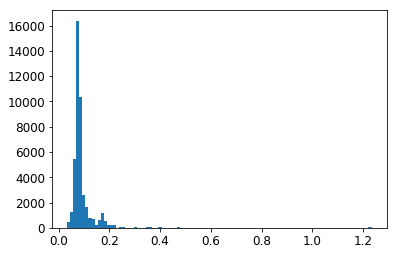

In [55]:
plt.hist(cosmos_coverage[~np.isnan(cosmos_coverage['ferr_irac_i1_mean'])]['ferr_irac_i1_mean'], bins=100)

In [56]:
#We use total here because apertur fluxes are absent
cosmos_coverage['ferr_irac_i1_mean'].name = 'ferr_ap_irac_i1_mean'
cosmos_coverage['ferr_irac_i2_mean'].name = 'ferr_ap_irac_i2_mean'
cosmos_coverage['ferr_irac_i3_mean'].name = 'ferr_ap_irac_i3_mean'
cosmos_coverage['ferr_irac_i4_mean'].name = 'ferr_ap_irac_i4_mean'

In [57]:
cosmos_coverage['hp_idx_O_10'].name='hp_idx_o_10'

In [58]:
len(cosmos_coverage)

99243

In [59]:
len(np.unique(cosmos_coverage['hp_idx_o_10']))

1645

In [60]:
cosmos_coverage.sort('hp_idx_o_10')
is_duplicate = cosmos_coverage['hp_idx_o_10'][1:] == cosmos_coverage['hp_idx_o_10'][:-1]
#np.append(is_duplicate,False)
cosmos_coverage = cosmos_coverage[~np.append(is_duplicate,False)]

In [61]:
len(cosmos_coverage)

1645

In [62]:
shared_cols = set(cosmos_coverage.colnames).intersection(set(depth_table.colnames))

In [63]:
shared_cols

{'ferr_ap_decam_g_mean',
 'ferr_ap_decam_r_mean',
 'ferr_ap_decam_z_mean',
 'ferr_ap_gpc1_g_mean',
 'ferr_ap_gpc1_i_mean',
 'ferr_ap_gpc1_r_mean',
 'ferr_ap_gpc1_y_mean',
 'ferr_ap_gpc1_z_mean',
 'ferr_ap_irac_i1_mean',
 'ferr_ap_irac_i2_mean',
 'ferr_ap_irac_i3_mean',
 'ferr_ap_irac_i4_mean',
 'ferr_ap_megacam_g_mean',
 'ferr_ap_megacam_i_mean',
 'ferr_ap_megacam_r_mean',
 'ferr_ap_megacam_u_mean',
 'ferr_ap_megacam_z_mean',
 'ferr_ap_omegacam_g_mean',
 'ferr_ap_omegacam_i_mean',
 'ferr_ap_omegacam_r_mean',
 'ferr_ap_omegacam_u_mean',
 'ferr_ap_suprime_g_mean',
 'ferr_ap_suprime_i_mean',
 'ferr_ap_suprime_r_mean',
 'ferr_ap_suprime_y_mean',
 'ferr_ap_suprime_z_mean',
 'ferr_ap_ukidss_h_mean',
 'ferr_ap_ukidss_j_mean',
 'ferr_ap_ukidss_k_mean',
 'ferr_ap_ukidss_y_mean',
 'ferr_ap_vista_h_mean',
 'ferr_ap_vista_j_mean',
 'ferr_ap_vista_ks_mean',
 'ferr_ap_vista_y_mean',
 'ferr_ap_wircam_h_mean',
 'ferr_ap_wircam_j_mean',
 'ferr_ap_wircam_ks_mean',
 'hp_idx_o_10'}

In [64]:
cosmos_pixels = np.in1d(depth_table['hp_idx_o_10'], np.unique(cosmos_coverage['hp_idx_o_10']))

In [65]:
np.sum(cosmos_pixels)

1645

In [66]:
len(depth_table)

394298

In [67]:
depth_table= depth_table[~cosmos_pixels]
len(depth_table)

392653

In [68]:

depth_table = vstack([depth_table, cosmos_coverage[list(shared_cols)]])
len(depth_table)

394298

In [69]:

for col in depth_table.colnames:
    if depth_table[col].dtype == 'float64':
        depth_table[col].fill_value = np.nan
    if col.startswith('ferr'):
        depth_table[col][depth_table[col] < 1.e-3] *= 1.e6 
    
depth_table = depth_table.filled()
coverage = Table()
coverage.add_column(Column(data=depth_table['hp_idx_o_10'], name='hp_idx_o_10'))
for band in bands:
    specific_bands = [f for f in filters if f.split('_')[1] == band.lower()]
    print(specific_bands)
    for specific_band in specific_bands:
        if 'ferr_ap_{}_mean'.format(specific_band) not in depth_table.colnames:
            specific_bands.remove(specific_band)
    print(specific_bands)
    lowest_depths = np.nanmin([depth_table[column] for column in 
                               ['ferr_ap_{}_mean'.format(s) for s in specific_bands]]
                              , axis=0)
    
    coverage.add_column(Column(data=lowest_depths, name='ferr_ap_{}_mean_min'.format(band)))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/env

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


['omegacam_u', 'mmt_u', 'bessell_u', 'lbc_u', 'wfi_u', 'megacam_u', 'mosaic_u', 'wfc_u', 'sdss_u']
['omegacam_u', 'mmt_u', 'bessell_u', 'wfi_u', 'megacam_u', 'mosaic_u', 'wfc_u', 'sdss_u']
['mmt_g', 'omegacam_g', 'suprime_g', 'megacam_g', 'wfc_g', 'gpc1_g', 'decam_g', '90prime_g', 'sdss_g']
['mmt_g', 'omegacam_g', 'suprime_g', 'megacam_g', 'wfc_g', 'gpc1_g', 'decam_g', '90prime_g', 'sdss_g']
['omegacam_r', 'mmt_r', 'cfht12k_r', 'megacam_r', 'wfi_r', 'suprime_r', 'mosaic_r', 'bessell_r', 'wfc_r', 'gpc1_r', 'decam_r', 'sdss_r', '90prime_r']
['omegacam_r', 'mmt_r', 'cfht12k_r', 'megacam_r', 'wfi_r', 'suprime_r', 'mosaic_r', 'bessell_r', 'wfc_r', 'gpc1_r', 'decam_r', 'sdss_r', '90prime_r']
['sdss_i', 'decam_i', 'gpc1_i', 'wfc_i', 'bessell_i', 'mosaic_i', 'megacam_i', 'wfi_i', 'suprime_i', 'cfht12k_i', 'mmt_i', 'omegacam_i']
['sdss_i', 'decam_i', 'gpc1_i', 'wfc_i', 'bessell_i', 'mosaic_i', 'megacam_i', 'wfi_i', 'suprime_i', 'cfht12k_i', 'mmt_i', 'omegacam_i']
['decam_z', '90prime_z', 'sdss_

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: All-NaN axis encountered


['omega2000_j', 'ukidss_j', 'vista_j', 'newfirm_j', 'wircs_j', 'wircam_j']
['omega2000_j', 'ukidss_j', 'vista_j', 'newfirm_j', 'wircs_j', 'wircam_j']
['ukidss_h', 'vista_h', 'newfirm_h', 'wircam_h']
['ukidss_h', 'vista_h', 'newfirm_h', 'wircam_h']
['isaac_k', 'moircs_k', 'ukidss_k', 'newfirm_k', 'wircs_k', 'hawki_k']
['isaac_k', 'moircs_k', 'ukidss_k', 'newfirm_k', 'wircs_k', 'hawki_k']
['wircam_ks', 'vista_ks', 'moircs_ks', 'omega2000_ks', 'tifkam_ks']
['wircam_ks', 'vista_ks', 'moircs_ks', 'omega2000_ks', 'tifkam_ks']
['irac_i1']
['irac_i1']
['irac_i2']
['irac_i2']
['irac_i3']
['irac_i3']
['irac_i4']
['irac_i4']


In [70]:
coverage

hp_idx_o_10,ferr_ap_u_mean_min,ferr_ap_g_mean_min,ferr_ap_r_mean_min,ferr_ap_i_mean_min,ferr_ap_z_mean_min,ferr_ap_y_mean_min,ferr_ap_J_mean_min,ferr_ap_H_mean_min,ferr_ap_K_mean_min,ferr_ap_Ks_mean_min,ferr_ap_i1_mean_min,ferr_ap_i2_mean_min,ferr_ap_i3_mean_min,ferr_ap_i4_mean_min
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1048576,0.3888968,0.01926224,0.030870374,0.041768204,0.06151843,0.14352015,1.92945241928101,1.7355504155159,6.3801355,2.36790292603629,nan,nan,nan,nan
1048577,0.3287,0.020717567,0.03293594,0.044771805,0.06634453,0.1526159,1.91976457834244,1.66691474914551,6.573922,2.3642338684627,nan,nan,nan,nan
1048578,0.3846171,0.021378249,0.035876982,0.047181558,0.06980607,0.15956911,2.23670622490454,2.36486881526548,6.919189,3.06828086159446,nan,nan,nan,nan
1048579,0.37277982,0.021092668,0.03373764,0.04277464,0.063606665,0.14877433,2.08620972292764,1.8796404004097,6.4581065,2.60780441455352,nan,nan,nan,nan
1048580,0.2911744,0.020199573,0.03168788,0.042326976,0.06250173,0.14537382,1.78109755970183,1.78018177407128,5.6970916,2.52248514782299,nan,nan,nan,nan
1048581,0.33193266,0.022394473,0.03486983,0.04694038,0.069550596,0.16066769,1.90774633487066,2.03642669806244,6.03468,2.77342678705851,nan,nan,nan,nan
1048582,0.31823373,0.020951325,0.033160187,0.04638167,0.06910887,0.16291834,1.95878115219948,1.83907379195804,6.4513354,2.62036830054389,nan,nan,nan,nan
1048583,0.25143299,0.020383537,0.031862717,0.04413113,0.06531107,0.1515935,1.84046977950681,1.75781759311413,5.647315,2.52217631393604,nan,nan,nan,nan
1048584,0.36621407,0.022677435,0.03732341,0.045192935,0.06752495,0.15900145,1.98236000979388,1.81433707039531,6.44909,2.55789082050323,nan,nan,nan,nan


In [71]:
#for m, band in enumerate(bands):
#    field_coverages.add_column(Column(data=np.full(len(field_coverages), np.nan), name='ferr_ap_{}_mean_median'.format(band)))

fields_table = Table()
for n, field in enumerate(fields['fields']):
    field_moc = MOC(filename=field['region'].replace('dmu_products/', '../../../'))
    field_cells= Table()
    field_cells.add_column(Column(data=list(field_moc.flattened(order=10)), name='hp_idx_o_10'))
    field_cells.add_column(Column(data=np.full(len(field_cells), field['name'] ), name='field'))
    fields_table = vstack([fields_table, field_cells])
                           


In [72]:
coverage = join(coverage, fields_table, join_type='left', keys='hp_idx_o_10')

In [73]:
coverage.write('./data/coverage_band_overview.fits', overwrite=True)

In [108]:
coverage = Table.read('./data/coverage_band_overview.fits')

In [109]:
coverage

hp_idx_o_10,ferr_ap_u_mean_min,ferr_ap_g_mean_min,ferr_ap_r_mean_min,ferr_ap_i_mean_min,ferr_ap_z_mean_min,ferr_ap_y_mean_min,ferr_ap_J_mean_min,ferr_ap_H_mean_min,ferr_ap_K_mean_min,ferr_ap_Ks_mean_min,ferr_ap_i1_mean_min,ferr_ap_i2_mean_min,ferr_ap_i3_mean_min,ferr_ap_i4_mean_min,field
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18
1048576,0.3888968,0.01926224,0.030870374,0.041768204,0.06151843,0.14352015,1.92945241928101,1.7355504155159,6.3801355,2.36790292603629,nan,nan,nan,nan,GAMA-09
1048577,0.3287,0.020717567,0.03293594,0.044771805,0.06634453,0.1526159,1.91976457834244,1.66691474914551,6.573922,2.3642338684627,nan,nan,nan,nan,GAMA-09
1048578,0.3846171,0.021378249,0.035876982,0.047181558,0.06980607,0.15956911,2.23670622490454,2.36486881526548,6.919189,3.06828086159446,nan,nan,nan,nan,GAMA-09
1048579,0.37277982,0.021092668,0.03373764,0.04277464,0.063606665,0.14877433,2.08620972292764,1.8796404004097,6.4581065,2.60780441455352,nan,nan,nan,nan,GAMA-09
1048580,0.2911744,0.020199573,0.03168788,0.042326976,0.06250173,0.14537382,1.78109755970183,1.78018177407128,5.6970916,2.52248514782299,nan,nan,nan,nan,GAMA-09
1048581,0.33193266,0.022394473,0.03486983,0.04694038,0.069550596,0.16066769,1.90774633487066,2.03642669806244,6.03468,2.77342678705851,nan,nan,nan,nan,GAMA-09
1048582,0.31823373,0.020951325,0.033160187,0.04638167,0.06910887,0.16291834,1.95878115219948,1.83907379195804,6.4513354,2.62036830054389,nan,nan,nan,nan,GAMA-09
1048583,0.25143299,0.020383537,0.031862717,0.04413113,0.06531107,0.1515935,1.84046977950681,1.75781759311413,5.647315,2.52217631393604,nan,nan,nan,nan,GAMA-09
1048584,0.36621407,0.022677435,0.03732341,0.045192935,0.06752495,0.15900145,1.98236000979388,1.81433707039531,6.44909,2.55789082050323,nan,nan,nan,nan,GAMA-09


## Make field summaries

In [110]:
order10_area = MOC(order=10, cells=[1]).area_sq_deg
order10_area

0.0032784908016061202

In [111]:
#Make a list of all bands
#this was too slow so tried to run whole query at once
field_coverages = Table()
field_coverages.add_column(Column(data=[field['name'] for field in fields['fields']], name='field' ))

for m, band in enumerate(bands):
    field_coverages.add_column(Column(data=np.full(len(field_coverages), np.nan), 
                                      name='{}_band_area'.format(band)))
    field_coverages.add_column(Column(data=np.full(len(field_coverages), np.nan), 
                                      name='ferr_ap_{}_mean_meadian'.format(band)))


for n, field in enumerate(fields['fields']):
    in_field = coverage['field'] == field['name']
    for m, band in enumerate(bands):
        has_band = in_field & ~np.isnan(coverage['ferr_ap_{}_mean_min'.format(band)])
        area = np.sum(has_band) * order10_area
        
        field_coverages['{}_band_area'.format(band)][field_coverages['field'] == field['name']] = area
        
        if np.sum(has_band) != 0:
            depth_median = np.nanmedian(coverage['ferr_ap_{}_mean_min'.format(band)][has_band])
            depth_max = np.nanmax(coverage['ferr_ap_{}_mean_min'.format(band)][has_band])
        else:
            depth_median = np.nan
            depth_max = np.nan
        
        field_coverages['ferr_ap_{}_mean_meadian'.format(band)][field_coverages['field'] == field['name']] = depth_median
        
        if band == 'i1':
            print("Field: {}, {} band coverage: {}, median depth = {}, max depth = {}".format(field['name'],
                                                       band,
                                                       area,
                                                       depth_median,
                                                       depth_max))
        
        
            

NameError: name 'fields' is not defined

In [112]:
field_coverages

<Table length=0>
<No columns>

In [113]:
field_coverages['field', 'ferr_ap_i1_mean_meadian'][field_coverages['ferr_ap_i1_mean_meadian'] > 10]

KeyError: 'field'

In [114]:
field_coverages.write('./data/field_coverages_band_overview.fits', overwrite=True)

In [115]:
field_coverages = Table.read('./data/field_coverages_band_overview.fits')

In [116]:
table = 'field '
for band in bands:
    table += '& \\multicolumn{2}{c}{' + band + '}'
    
table += ' \\\\ \n'

table += '\\cline{1-29} \n'

for band in bands:
    table += '& a & \\sigma '

table += '\\\\ \n'

In [117]:
len('AKARI-NEP&&&9.6&1.5&9.6&1.6&9.6&1.5&9.6&3.2&9.6&7.2&&&&&&&&&7.2&1.7&7.2&1.4&&&&\\'.split('&'))

29

In [118]:
print(table)

field & \multicolumn{2}{c}{u}& \multicolumn{2}{c}{g}& \multicolumn{2}{c}{r}& \multicolumn{2}{c}{i}& \multicolumn{2}{c}{z}& \multicolumn{2}{c}{y}& \multicolumn{2}{c}{J}& \multicolumn{2}{c}{H}& \multicolumn{2}{c}{K}& \multicolumn{2}{c}{Ks}& \multicolumn{2}{c}{i1}& \multicolumn{2}{c}{i2}& \multicolumn{2}{c}{i3}& \multicolumn{2}{c}{i4} \\ 
\cline{1-29} 
& a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma \\ 



In [119]:


for n, field in enumerate(field_coverages):
    latex = ''
    for element in field:


        if isinstance(element , float):
            if np.isnan(element):
                element = ''
            elif np.isclose(element, 0.0):
                element = ''
            else:
                element = round(element,1)


        
        latex +=  str(element) + '&' 
    print(latex[:-1] + '\\\\')
    table += latex[:-1] + '\\\\ \n'

table += '\\hline'

In [120]:
print(table)

field & \multicolumn{2}{c}{u}& \multicolumn{2}{c}{g}& \multicolumn{2}{c}{r}& \multicolumn{2}{c}{i}& \multicolumn{2}{c}{z}& \multicolumn{2}{c}{y}& \multicolumn{2}{c}{J}& \multicolumn{2}{c}{H}& \multicolumn{2}{c}{K}& \multicolumn{2}{c}{Ks}& \multicolumn{2}{c}{i1}& \multicolumn{2}{c}{i2}& \multicolumn{2}{c}{i3}& \multicolumn{2}{c}{i4} \\ 
\cline{1-29} 
& a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma & a & \sigma \\ 
\hline


In [121]:
round(np.nan,2)

nan

## Plot general overview of depths

In [123]:
def depths_sample(band):
    mask = ~np.isnan(coverage['ferr_ap_{}_mean_min'.format(band)])
    mask &= coverage['ferr_ap_{}_mean_min'.format(band)] > 0.
    mask &= coverage['ferr_ap_{}_mean_min'.format(band)] <1.e3
    area = (np.sum(mask)/len(coverage)) * 1270.
    return np.log10(np.array(coverage['ferr_ap_{}_mean_min'.format(band)][mask]) *5.e-6 ), area
    

data = [ depths_sample(band)[0] for band in bands ]
areas = [ depths_sample(band)[1] for band in bands ]

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [124]:
bands

['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'K', 'Ks', 'i1', 'i2', 'i3', 'i4']

In [125]:
bands_fir = ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'K', 'Ks', 'i1', 'i2', 'i3', 'i4', 
             '24', '100', '160', '250', '350', '500']

In [126]:
en1_depths = Table.read('../../../dmu32/dmu32_ELAIS-N1/data/depths_elais-n1_20171016.fits'
                       )['hp_idx_O_10', 
           'ferr_mips_24_mean',
           'ferr_pacs_green_mean',
           'ferr_pacs_red_mean',
           'ferr_spire_250_mean',
           'ferr_spire_350_mean',
           'ferr_spire_500_mean']
en1_depths['hp_idx_O_10'].name = 'hp_idx_o_10'

In [127]:
len(en1_depths)

263682

In [128]:
en1_depths.sort('hp_idx_o_10')
is_duplicate = en1_depths['hp_idx_o_10'][1:] == en1_depths['hp_idx_o_10'][:-1]
#np.append(is_duplicate,False)
en1_coverage = en1_depths[~np.append(is_duplicate,False)]

In [129]:
len(en1_coverage)

4265

In [130]:
full_coverage = join(coverage, en1_coverage, join_type='left', keys='hp_idx_o_10')

In [131]:
full_coverage

hp_idx_o_10,ferr_ap_u_mean_min,ferr_ap_g_mean_min,ferr_ap_r_mean_min,ferr_ap_i_mean_min,ferr_ap_z_mean_min,ferr_ap_y_mean_min,ferr_ap_J_mean_min,ferr_ap_H_mean_min,ferr_ap_K_mean_min,ferr_ap_Ks_mean_min,ferr_ap_i1_mean_min,ferr_ap_i2_mean_min,ferr_ap_i3_mean_min,ferr_ap_i4_mean_min,field,ferr_mips_24_mean,ferr_pacs_green_mean,ferr_pacs_red_mean,ferr_spire_250_mean,ferr_spire_350_mean,ferr_spire_500_mean
,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,uJy,uJy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float32,float32,float64,float64,float64
1048576,0.3888968,0.01926224,0.030870374,0.041768204,0.06151843,0.14352015,1.92945241928101,1.7355504155159,6.3801355,2.36790292603629,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048577,0.3287,0.020717567,0.03293594,0.044771805,0.06634453,0.1526159,1.91976457834244,1.66691474914551,6.573922,2.3642338684627,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048578,0.3846171,0.021378249,0.035876982,0.047181558,0.06980607,0.15956911,2.23670622490454,2.36486881526548,6.919189,3.06828086159446,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048579,0.37277982,0.021092668,0.03373764,0.04277464,0.063606665,0.14877433,2.08620972292764,1.8796404004097,6.4581065,2.60780441455352,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048580,0.2911744,0.020199573,0.03168788,0.042326976,0.06250173,0.14537382,1.78109755970183,1.78018177407128,5.6970916,2.52248514782299,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048581,0.33193266,0.022394473,0.03486983,0.04694038,0.069550596,0.16066769,1.90774633487066,2.03642669806244,6.03468,2.77342678705851,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048582,0.31823373,0.020951325,0.033160187,0.04638167,0.06910887,0.16291834,1.95878115219948,1.83907379195804,6.4513354,2.62036830054389,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--
1048583,0.25143299,0.020383537,0.031862717,0.04413113,0.06531107,0.1515935,1.84046977950681,1.75781759311413,5.647315,2.52217631393604,nan,nan,nan,nan,GAMA-09,--,--,--,--,--,--


In [132]:
full_names = {
    '24':'mips_24', 
    '100':'pacs_green', 
    '160':'pacs_red', 
    '250':'spire_250', 
    '350':'spire_350', 
    '500':'spire_500'
}
def depths_sample(band):
    if band in ['24', '100', '160', '250', '350', '500']:
        band = full_names[band] 
        mask = ~np.isnan(full_coverage['ferr_{}_mean'.format(band)])
        mask &= full_coverage['ferr_{}_mean'.format(band)] > 0.
        #mask &= full_coverage['ferr_{}_mean'.format(band)] <1.e3
        area = (np.sum(mask)/len(full_coverage)) * 1270. * (1270./14.)
        return np.log10(np.array(full_coverage['ferr_{}_mean'.format(band)][mask]) *5.e-6 ), area
    else:
        mask = ~np.isnan(coverage['ferr_ap_{}_mean_min'.format(band)])
        mask &= full_coverage['ferr_ap_{}_mean_min'.format(band)] > 0.
        mask &= full_coverage['ferr_ap_{}_mean_min'.format(band)] <1.e3
        area = (np.sum(mask)/len(full_coverage)) * 1270.
        return np.log10(np.array(full_coverage['ferr_ap_{}_mean_min'.format(band)][mask]) *5.e-6 ), area
    

data = [ depths_sample(band)[0] for band in bands_fir ]
areas = [ depths_sample(band)[1] for band in bands_fir ]

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [133]:
len(data)

20

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


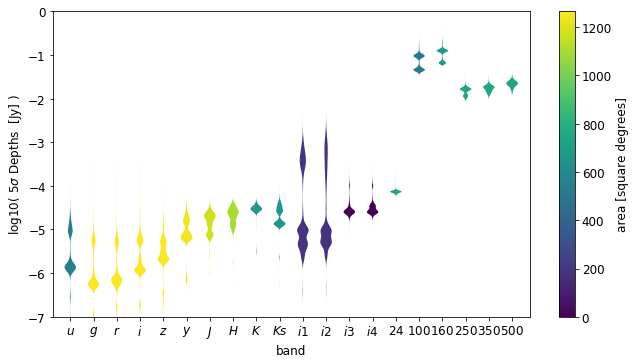

In [134]:


# fake data
fs = 10  # fontsize
#pos = [1, 2, 4, 5, 7, 8]
#data = np.array([np.array(coverage['ferr_ap_{}_mean_min'.format(b)]) for b in bands]).T

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)   # The color is the angle
colors[:, 3] = 1

fig, ax = plt.subplots()

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('band')

#ax.violinplot(np.array(coverage['ferr_ap_{}_mean_min'.format('g') ] ) )
#ax.set_title('Custom violinplot 1', fontsize=fs)

ax.set_ylabel('log10( 5$\sigma$ Depths  [Jy] )')
set_axis_style(ax, ['$' + band + '$' for band in bands_fir])
ax.set_ylim(-7, 0)



parts = ax.violinplot(data, showmeans=False, showmedians=False,
        showextrema=False)

for n, part in enumerate(parts['bodies']):
    part.set_facecolor(colors[n])
    part.set_alpha(1)

cax, _ = mpl.colorbar.make_axes(ax)
n_ticks = 7
values = np.linspace(0,1200, n_ticks)
ticks = values/np.max(areas)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = ticks)
cax.set_yticklabels([int(d) for d in values])
cbar.set_label('area [square degrees]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

#fig.suptitle("Violin Plotting Examples")
#fig.subplots_adjust(hspace=0.4)
#plt.ylim(-10,10)
column_width_cm = 8.9
width_cm = 3.0 * column_width_cm
hieght_cm = width_cm / 1.9
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/band_depths_overviews.pdf', bbox_inches='tight')
plt.savefig('./figs/band_depths_overviews.png', bbox_inches='tight')

In [135]:
widths = [np.max(np.histogram(data[n], bins = 100, density = True)[0])*areas[n] for n in np.arange(len(data)) ]
widths /= np.max(widths)

print(widths)

[0.12543783 0.28233033 0.2600706  0.27458386 0.2332077  0.23691955
 0.22385508 0.22926965 0.36306825 0.20109221 0.06786699 0.06636376
 0.02697374 0.02281629 1.         0.50937929 0.75651191 0.47791881
 0.40442308 0.39960632]


/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


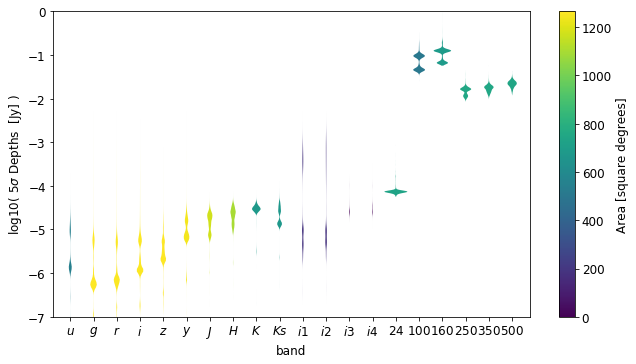

In [136]:
# fake data
fs = 10  # fontsize
#pos = [1, 2, 4, 5, 7, 8]
#data = np.array([np.array(coverage['ferr_ap_{}_mean_min'.format(b)]) for b in bands]).T

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)   # The color is the angle
colors[:, 3] = 1

fig, ax = plt.subplots()

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('band')

#ax.violinplot(np.array(coverage['ferr_ap_{}_mean_min'.format('g') ] ) )
#ax.set_title('Custom violinplot 1', fontsize=fs)

ax.set_ylabel('log10( 5$\sigma$ Depths  [Jy] )')
set_axis_style(ax, ['$' + band + '$' for band in bands_fir])
ax.set_ylim(-7, 0)


#areas/np.max(areas)
parts = ax.violinplot(data, widths=widths, showmeans=False, showmedians=False,
        showextrema=False)

for n, part in enumerate(parts['bodies']):
    part.set_facecolor(colors[n])
    part.set_alpha(1)

cax, _ = mpl.colorbar.make_axes(ax)
n_ticks = 7
values = np.linspace(0,1200, n_ticks)
ticks = values/np.max(areas)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = ticks)
cax.set_yticklabels([int(d) for d in values])
cbar.set_label('Area [square degrees]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

#fig.suptitle("Violin Plotting Examples")
#fig.subplots_adjust(hspace=0.4)
#plt.ylim(-10,10)
column_width_cm = 8.9
width_cm = 3.0 * column_width_cm
hieght_cm = width_cm / 1.9
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/band_depths_overviews_areaweighted.pdf', bbox_inches='tight')
plt.savefig('./figs/band_depths_overviews_areaweighted.png', bbox_inches='tight')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


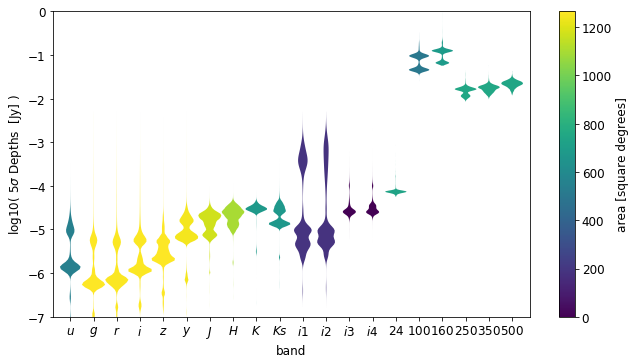

In [137]:
# fake data
fs = 10  # fontsize
#pos = [1, 2, 4, 5, 7, 8]
#data = np.array([np.array(coverage['ferr_ap_{}_mean_min'.format(b)]) for b in bands]).T

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)   # The color is the angle
colors[:, 3] = 1

fig, ax = plt.subplots()

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('band')

#ax.violinplot(np.array(coverage['ferr_ap_{}_mean_min'.format('g') ] ) )
#ax.set_title('Custom violinplot 1', fontsize=fs)

ax.set_ylabel('log10( 5$\sigma$ Depths  [Jy] )')
set_axis_style(ax, ['$' + band + '$' for band in bands_fir])
ax.set_ylim(-7, 0)



parts = ax.violinplot(data, widths=np.log10(areas)/np.log10(np.max(areas)), showmeans=False, showmedians=False,
        showextrema=False)

for n, part in enumerate(parts['bodies']):
    part.set_facecolor(colors[n])
    part.set_alpha(1)

cax, _ = mpl.colorbar.make_axes(ax)
n_ticks = 7
values = np.linspace(0,1200, n_ticks)
ticks = values/np.max(areas)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = ticks)
cax.set_yticklabels([int(d) for d in values])
cbar.set_label('area [square degrees]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

#fig.suptitle("Violin Plotting Examples")
#fig.subplots_adjust(hspace=0.4)
#plt.ylim(-10,10)
column_width_cm = 8.9
width_cm = 3.0 * column_width_cm
hieght_cm = width_cm / 1.9
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/band_depths_overviews_logareaweighted.pdf', bbox_inches='tight')
plt.savefig('./figs/band_depths_overviews_logareaweighted.png', bbox_inches='tight')

## Add SED to plot

In [138]:
#s.add_contribution("HELP_SED", orig_spec['WAVE'], orig_spec['LUMIN'])

In [139]:
cigale_filternames = {
    'u':  'u_prime',
    'g':  'MCam_g',
    'r':  'MCam_r',
    'i':  'MCam_i',
    'z':  'MCam_z',
    'y':  'WFCAM_Y',
    'J':  'WFCAM_J',
    'H':  'WFI_H',
    'K':  'WFI_K',
    'Ks': 'Ks_2mass',
    'i1': 'IRAC1',
    'i2': 'IRAC2',
    'i3': 'IRAC3',
    'i4': 'IRAC4'
}

In [140]:



gal1 = './data/HELP_J095946.083p021914.438_best_model.fits'
gal2 = './data/HELP_J100130.443p020929.494_best_model.fits'
gal3 = './data/HELP_J095809.302p013203.775_best_model.fits'
gal4 = './data/HELP_J095822.986p013145.336_best_model.figs'
gal5 = './data/HELP_J003412.527-441056.846_best_model.fits'  #z=4
gal6 = './data/HELP_J095738.934+021508.530_best_model.fits' #From hedam - high fluxes
gal7 = './data/HELP_J095818.598+013057.910_best_model.fits'
gal8 = './data/HELP_J095809.488+013225.513_best_model.fits'
gal9 = './data/HELP_J100108.952+022730.528_best_model.fits'
orig_spec = Table.read(gal9)
        
s = SED()
    # This is wrong because the best SED we get from CIGALE is redshifted (written by Yannick)
s.add_contribution("HELP_SED", orig_spec['wavelength'], orig_spec['L_lambda_total'])
    
#z=1
zs = np.arange(1, 5, 1)




In [141]:
gal_fluxes = np.full([len(zs), len(bands)], np.nan)

z = 1:
z = 2:
z = 3:
z = 4:


(-7, 0)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


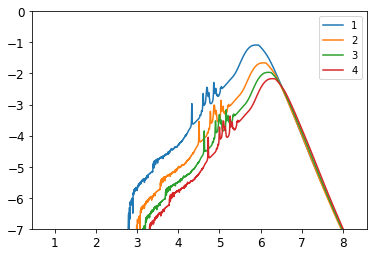

In [142]:
fig, ax = plt.subplots()
for n, z in enumerate(zs):
    print('z = {}:'.format(z))
    sed = s.copy()
    mod = get_module("redshifting", redshift=z)
    mod.process(sed)
    ax.plot(np.log10(sed.wavelength_grid), np.log10(sed.fnu * 1.e-3), label=str(z))
#ax.plot(np.log10(orig_spec['wavelength']), np.log10(orig_spec['Fnu']))

plt.legend()
ax.set_ylim(-7, 0)
#ax.set_xlim(0, 14.75)

In [143]:
pos = [3561.,     #u  (SDSS)
       4866.,     #g  (GPC1)
       6215.,     #r  (GPC1)
       7545.,     #i  (GPC1)
       8680.,     #z  (GPC1)
       9633.,     #y  (GPC1)
       12510.,    #J  (UKIRT)
       16377.,    #H  (UKIRT)
       22081.,    #K   (UKIRT)
       21496.,    #Ks (WIRCam)
       36000.,    #i1
       45000.,    #i2 
       56000.,    #i3
       80000.,    #i4
       240000.,    #mips_24
       1000000.,    #pacs_100
       1600000.,    #pacs_160
       2500000.,    #spire_250
       3500000.,    #spire_350
       5000000.,    #spire_500
      ]   
fwhms = [
       [3048., 4028.],     #u  (SDSS)
       [3943., 5593.],     #g  (GPC1)
       [5386., 7036.],     #r  (GPC1)
       [6778., 8304.],     #i  (GPC1)
       [8028., 9346.],     #z  (GPC1)
       [9100., 10838.],     #y  (GPC1)
       [11690., 13280],     #J  (UKIRT)
       [14920., 17840.],     #H  (UKIRT)
       [20290., 23800.],     #K   (UKIRT)
       [19578., 23431.],     #Ks (WIRCam)
       [31296, 39614 ],     #i1
       [39173, 50561],      #i2 
       [48983, 65089],     #i3
       [62994, 95876],      #i4
       [240000.,340000.],    #mips_24 GUESSES!!!!
       [1000000.,1500000.],    #pacs_100
       [1600000.,1900000.],    #pacs_160
       [2500000.,3000000.],    #spire_250
       [3500000.,4000000.],    #spire_350
       [5000000.,5500000.]    #spire_500
        ]

In [144]:
['${}$'.format(band).replace(
    '$Ks$', '').replace(
    'K', 'K/Ks').replace(
     '100', 'PACS 100/160').replace(
     '160', ' ').replace(
     '250', 'SPIRE 250/350/500').replace(
     '350', ' ').replace(
     '500', ' ') for band in bands_fir]

['$u$',
 '$g$',
 '$r$',
 '$i$',
 '$z$',
 '$y$',
 '$J$',
 '$H$',
 '$K/Ks$',
 '',
 '$i1$',
 '$i2$',
 '$i3$',
 '$i4$',
 '$24$',
 '$PACS 100/ $',
 '$ $',
 '$SPIRE 250/ / $',
 '$ $',
 '$ $']

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


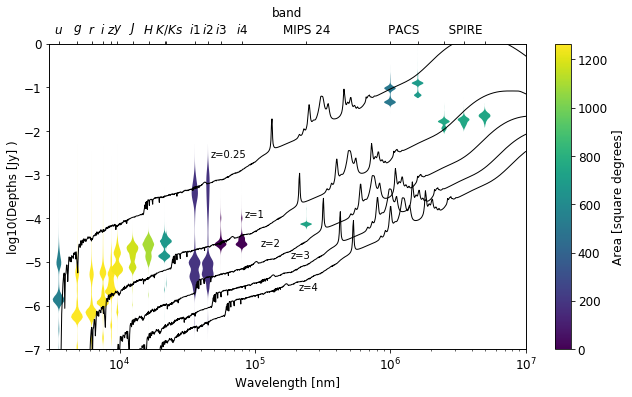

In [145]:
# fake data
fs = 10  # fontsize
# Angstroms     


#data = np.array([np.array(coverage['ferr_ap_{}_mean_min'.format(b)]) for b in bands]).T

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)   # The color is the angle
colors[:, 3] = 1

fig, ax = plt.subplots()

ax2 = ax.twiny()

#ax2.set_xlim(3000., 100000)
#ax2.set_xticks(pos)
#ax2.set_xticklabels(['$' + band + '$' for band in bands])
#ax2.set_xlabel('band')
#ax2.set_xscale('log')
ax2.set_xlim(np.log10(3000.), np.log10(10000000))
ax2.set_xticks(np.log10(pos))
ax2.set_xticklabels(['$u$',
 '$g$',
 '$r$',
 '$i$',
 '$z$',
 '$y$',
 '$J$',
 '$H$',
 '  $K/Ks$',
 '',
 '$i1$',
 '$i2$',
 '$i3$',
 '$i4$',
 'MIPS 24',
 '       PACS',
 '',
 '           SPIRE',
 '',
 ''])
ax2.set_xlabel('band')
#ax2.set_xscale('log')


line_styles = [':', '-.', '--', '-']
colours = ['y', 'b', 'g', 'r', 'k']
for n, z in enumerate([0.25, 1, 2, 3, 4]):
    sed = s.copy()
    mod = get_module("redshifting", redshift=z)
    mod.process(sed)
    ax.plot(sed.wavelength_grid*10, 
            np.log10(sed.fnu * 1.e-3),
            c='k',
            #c= colours[n],
            #linestyle = line_styles[n],
            label= 'z = {}'.format(z),
            linewidth=1.0,
            alpha=1.
           )
    for m, band in enumerate(cigale_filternames):
        continue
        if m == 0:
            lab = 'z = {}'.format(z)
        else:
            lab=None
        ax.plot([fwhms[m][0], fwhms[m][1]], [np.log10(gal_fluxes[n, m]   )-3, 
                                     np.log10(gal_fluxes[n, m]   )-3], 
               # c='k',
                c= colours[n],
               #linestyle = line_styles[n],
               label=lab,
                alpha=1.0
               )

        




ax.set_ylabel('log10(Depths [Jy] )')

#ax.set_xticks(pos)
#ax.set_xticklabels(['${}$'.format(band.replace('Ks', '').replace('K', 'K/Ks')) for band in bands])
ax.set_xlim(3000., 10000000)
ax.set_xscale('log')    
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim(-7, 0)
#ax.legend(loc=2)


#widths
log_widths = np.ones(len(pos)) * (pos) * .2# * widths
#log_widths = np.ones(len(pos)) * 1000.
#areas/np.max(areas)
parts = ax.violinplot(data, 
                      positions=pos, 
                      widths=log_widths, 
                      showmeans=False, 
                      showmedians=False, #widths=widths,
        showextrema=False)

for n, part in enumerate(parts['bodies']):
    part.set_facecolor(colors[n])
    part.set_alpha(1.0)

cax, _ = mpl.colorbar.make_axes([ax, ax2])
n_ticks = 7
values = np.linspace(0,1200, n_ticks)
ticks = values/np.max(areas)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = ticks)
cax.set_yticklabels([int(d) for d in values])
cbar.set_label('Area [square degrees]')



plt.figtext(0.335, 0.6, 'z=0.25')
plt.figtext(0.38, 0.45, 'z=1')
plt.figtext(0.4, 0.38, 'z=2')
plt.figtext(0.44, 0.35, 'z=3')
plt.figtext(0.45, 0.27, 'z=4')





plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

#fig.suptitle("Violin Plotting Examples")
#fig.subplots_adjust(hspace=0.4)
#plt.ylim(-10,10)
column_width_cm = 8.9
width_cm = 3.0 * column_width_cm
hieght_cm = width_cm / 1.9
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/band_depths_overviews_areaweighted_with_black_seds_wave.pdf', bbox_inches='tight')
plt.savefig('./figs/band_depths_overviews_areaweighted_with_black_seds_wave.png', bbox_inches='tight')

In [146]:
#take the median luminosity in a redshift bin?
#nu Lnu??

In [147]:
log_widths

array([7.1220e+02, 9.7320e+02, 1.2430e+03, 1.5090e+03, 1.7360e+03,
       1.9266e+03, 2.5020e+03, 3.2754e+03, 4.4162e+03, 4.2992e+03,
       7.2000e+03, 9.0000e+03, 1.1200e+04, 1.6000e+04, 4.8000e+04,
       2.0000e+05, 3.2000e+05, 5.0000e+05, 7.0000e+05, 1.0000e+06])

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


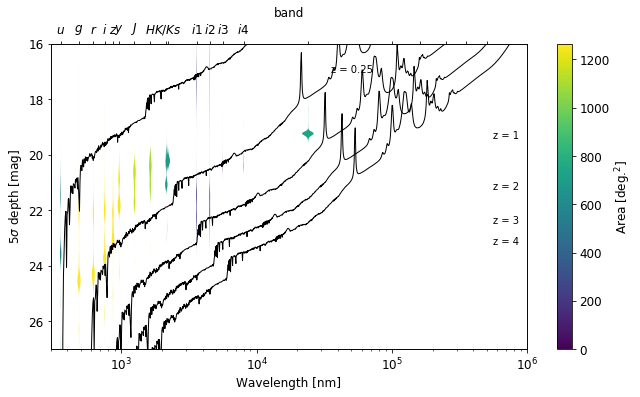

In [148]:
# fake data
fs = 10  # fontsize
# Angstroms     


#data = np.array([np.array(coverage['ferr_ap_{}_mean_min'.format(b)]) for b in bands]).T

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)   # The color is the angle
colors[:, 3] = 1

fig, ax = plt.subplots()

ax2 = ax.twiny()

#ax2.set_xlim(3000., 100000)
#ax2.set_xticks(pos)
#ax2.set_xticklabels(['$' + band + '$' for band in bands])
#ax2.set_xlabel('band')
#ax2.set_xscale('log')
ax2.set_xlim(np.log10(300.), np.log10(1000000))
ax2.set_xticks(np.log10(np.array(pos)/10))
ax2.set_xticklabels(['${}$'.format(band).replace('$Ks$', '').replace('K', 'K/Ks') for band in bands])
ax2.set_xlabel('band')
#ax2.set_xscale('log')


line_styles = [':', '-.', '--', '-']
colours = ['y', 'b', 'g', 'r', 'k']
for n, z in enumerate([0.25, 1, 2, 3, 4]):
    sed = s.copy()
    mod = get_module("redshifting", redshift=z)
    mod.process(sed)
    ax.plot(sed.wavelength_grid, #*10 factor ten turns angstrom to nm fix unit error
            #np.log10(sed.fnu * 1.e-3), #This is for flux in Jy
            flux_to_mag(sed.fnu * 1.e-3)[0], #This is for flux in mag
            c='k',
            #c= colours[n],
            #linestyle = line_styles[n],
            label= 'z = {}'.format(z),
            linewidth=1.0,
            alpha=1.
           )
    for m, band in enumerate(cigale_filternames):
        continue
        if m == 0:
            lab = 'z = {}'.format(z)
        else:
            lab=None
        ax.plot([fwhms[m][0], fwhms[m][1]], [np.log10(gal_fluxes[n, m]   )-3, 
                                     np.log10(gal_fluxes[n, m]   )-3], 
               # c='k',
                c= colours[n],
               #linestyle = line_styles[n],
               label=lab,
                alpha=1.0
               )

        




ax.set_ylabel('5$\sigma$ depth [mag]')

#ax.set_xticks(pos)
#ax.set_xticklabels(['${}$'.format(band.replace('Ks', '').replace('K', 'K/Ks')) for band in bands])
ax.set_xlim(300., 1000000)
ax.set_xscale('log')    
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim(27, 16)
#ax.legend(loc=2)


#widths
log_widths = np.ones(len(pos)) * (pos) * .2 * widths
#areas/np.max(areas)
parts = ax.violinplot([flux_to_mag(10**d)[0] for d in data], #flux_to_mag assumes Jy
                      positions=np.array(pos)/10, #fix unit error 
                      widths=log_widths/10, 
                      showmeans=False, 
                      showmedians=False, #widths=widths,
        showextrema=False)

for n, part in enumerate(parts['bodies']):
    part.set_facecolor(colors[n])
    part.set_alpha(1.0)

cax, _ = mpl.colorbar.make_axes([ax, ax2])
n_ticks = 7
values = np.linspace(0,1200, n_ticks)
ticks = values/np.max(areas)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = ticks)
cax.set_yticklabels([int(d) for d in values])
cbar.set_label('Area [deg.$^2$]')



plt.figtext(0.49, 0.81, 'z = 0.25')
plt.figtext(0.70, 0.645, 'z = 1')
plt.figtext(0.70, 0.52, 'z = 2')
plt.figtext(0.70, 0.435, 'z = 3')
plt.figtext(0.70, 0.385, 'z = 4')





plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

#fig.suptitle("Violin Plotting Examples")
#fig.subplots_adjust(hspace=0.4)
#plt.ylim(-10,10)
column_width_cm = 8.9
width_cm = 3.0 * column_width_cm
hieght_cm = width_cm / 1.9
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/band_depths_overviews_areaweighted_with_black_seds_wave_mag.pdf', bbox_inches='tight')
plt.savefig('./figs/band_depths_overviews_areaweighted_with_black_seds_wave_mag.png', bbox_inches='tight')

In [149]:
['${}$'.format(band).replace('$Ks$', '').replace('K', 'K/Ks') for band in bands]

['$u$',
 '$g$',
 '$r$',
 '$i$',
 '$z$',
 '$y$',
 '$J$',
 '$H$',
 '$K/Ks$',
 '',
 '$i1$',
 '$i2$',
 '$i3$',
 '$i4$']

In [150]:
data[0].shape

(204388,)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


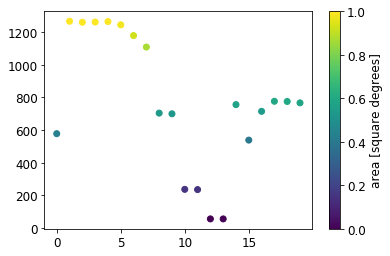

In [151]:


fig, ax = plt.subplots()
#cmap = mpl.cm.get_cmap('viridis', 256)
#norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.min(areas))

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)   # The color is the angle
colors[:, 3] = 1

#cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,  norm=norm)

#cmap = mpl.colors.ListedColormap('viridis')
#colors = cmap(np.array(areas))


im = plt.scatter(np.arange(len(areas)), areas, c=colors)


cax, _ = mpl.colorbar.make_axes(ax)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap)
cbar.set_label('area [square degrees]')
#cax.set_yticklabels(['$-\pi$', '0', '$\pi$'])
#cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,  norm=norm)
# Optionally add a colorbar
#cax, _ = mpl.colorbar.make_axes(ax)
#cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap)



In [152]:
colors

array([[0.151918, 0.500685, 0.557587, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.983868, 0.904867, 0.136897, 1.      ],
       [0.983868, 0.904867, 0.136897, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.9553  , 0.901065, 0.118128, 1.      ],
       [0.814576, 0.883393, 0.110347, 1.      ],
       [0.657642, 0.860219, 0.203082, 1.      ],
       [0.120092, 0.600104, 0.54253 , 1.      ],
       [0.120565, 0.596422, 0.543611, 1.      ],
       [0.273006, 0.20452 , 0.501721, 1.      ],
       [0.274128, 0.199721, 0.498911, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.12478 , 0.640461, 0.527068, 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ],
       [0.119512, 0.607464, 0.540218, 1.      ],
       [0.132268, 0.655014, 0.519661, 1.      ],
       [0.132268, 0.655014, 0.519661, 1.      ],
       [0.128087, 0.647749, 0.523491, 1.      ]])

In [153]:
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=np.min(areas), vmax=np.max(areas))
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)
colors = scalmap.to_rgba(areas)  # The color is the angle
#colors[:, 3] = 0.5
print(scalmap.to_rgba(500),
     scalmap.to_rgba(1000),
     scalmap.to_rgba(100))
colors

(0.9990204970624408, 0.0, 0.0, 1.0) (1.0, 1.0, 0.13529325294031186, 1.0) (0.13425359648991364, 0.0, 0.0, 1.0)


array([[1.        , 0.17402028, 0.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.98455881, 1.        ],
       [1.        , 1.        , 0.98455881, 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.93823523, 1.        ],
       [1.        , 1.        , 0.72205855, 1.        ],
       [1.        , 1.        , 0.49044067, 1.        ],
       [1.        , 0.45196101, 0.        , 1.        ],
       [1.        , 0.44166691, 0.        , 1.        ],
       [0.43280407, 0.        , 0.        , 1.        ],
       [0.42250923, 0.        , 0.        , 1.        ],
       [0.0416    , 0.        , 0.        , 1.        ],
       [0.0416    , 0.        , 0.        , 1.        ],
       [1.        , 0.56519612, 0.        , 1.        ],
       [1.        , 0.09166748, 0.        , 1.        ],
       [1.        , 0.47254921, 0.        , 1.        ],
       [1.        , 0.60637252,

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


(array([7.0000e+00, 1.7000e+01, 1.8600e+02, 3.4000e+02, 5.3000e+01,
        2.6000e+01, 3.5000e+01, 5.0000e+00, 2.8000e+01, 3.2990e+03,
        2.6680e+03, 5.9660e+03, 1.2033e+04, 4.6040e+03, 3.4370e+03,
        1.7157e+04, 2.4320e+03, 1.5290e+03, 4.9600e+02, 6.8100e+02,
        2.0300e+02, 1.0200e+02, 1.6800e+02, 2.9900e+02, 4.3800e+02,
        7.4700e+02, 1.4360e+03, 3.1540e+03, 5.1880e+03, 5.7870e+03,
        4.5870e+03, 3.0960e+03, 2.1500e+03, 1.0010e+03, 3.9300e+02,
        1.2300e+02, 6.0000e+01, 2.6000e+01, 1.3000e+01, 8.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-7.47225542, -7.35783564, -7.24341587, -7.1289961 , -7.01457632,
        -6.90015655, -6.78573678, -6.67131701, -6.55689723, -6.44247746,
        -6.32805769, -6.21363791, -6.09921814, -5.98479837, -5.8703786 ,
        -5.75595882, -5.64153905, -5.52711928, -5.4126995 , -5.29827973,
        -5.18385996, -5.06

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


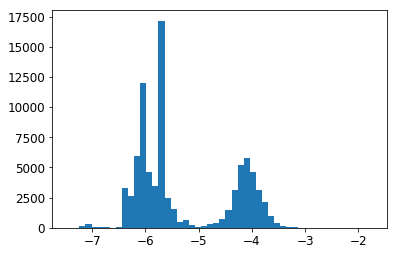

In [154]:
mask = ~np.isnan(coverage['ferr_ap_{}_mean_min'.format('i1')])
mask |= coverage['ferr_ap_{}_mean_min'.format('i1')] > 0.
mask |= coverage['ferr_ap_{}_mean_min'.format('i1')] <1.e3
plt.hist(np.log10(np.array(coverage['ferr_ap_{}_mean_min'.format('i1')][mask ]) *1.e-6), bins=50)

In [155]:
areas

[577.9251290226341,
 1265.6398587541692,
 1259.37392295601,
 1260.7368205438765,
 1263.7397193785541,
 1243.774117992813,
 1178.0100679957075,
 1107.8151870438564,
 703.7980523037053,
 699.5962560058423,
 237.4354218895415,
 235.95942076741193,
 56.67335343073299,
 56.5970085451056,
 755.6568306455871,
 538.6555819265895,
 714.6164053559421,
 776.1770432904094,
 774.894530000108,
 766.4299422841189]

In [156]:
np.sum(np.log10(coverage['ferr_ap_{}_mean_min'.format('i1')] )  >3)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


17

In [157]:
np.sum(coverage['ferr_ap_{}_mean_min'.format('i1')]  >10.)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


28723

## All field comparison

In [112]:
def depths_sample_field(band, field):
    
    mask = ~np.isnan(coverage['ferr_ap_{}_mean_min'.format(band)])
    mask &= coverage['ferr_ap_{}_mean_min'.format(band)] > 0.
    mask &= coverage['ferr_ap_{}_mean_min'.format(band)] <1.e3
    mask &= coverage['field'] == field
    area = (np.sum(mask)/len(coverage[coverage['field'] == field])) #* 1270. #Return fractional areas
    
    pixel_depths = np.log10(np.array(coverage['ferr_ap_{}_mean_min'.format(band)][mask]) *5.e-6 )
    if np.sum(mask)== 0:
        pixel_depths = np.full(100, -9.)
    return pixel_depths, area
    
f = 'ELAIS-N1'
data_field = [ depths_sample_field(band, f)[0] for band in bands ]
areas_field = [ depths_sample_field(band, f)[1] for band in bands ]

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [113]:
areas_field

[0.9446658851113716,
 0.994841735052755,
 0.9950762016412661,
 0.9939038686987104,
 0.9950762016412661,
 0.9894490035169988,
 0.6628370457209848,
 0.0,
 0.6640093786635405,
 0.0,
 0.6944900351699883,
 0.6958968347010551,
 0.6893317702227433,
 0.6902696365767879]

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


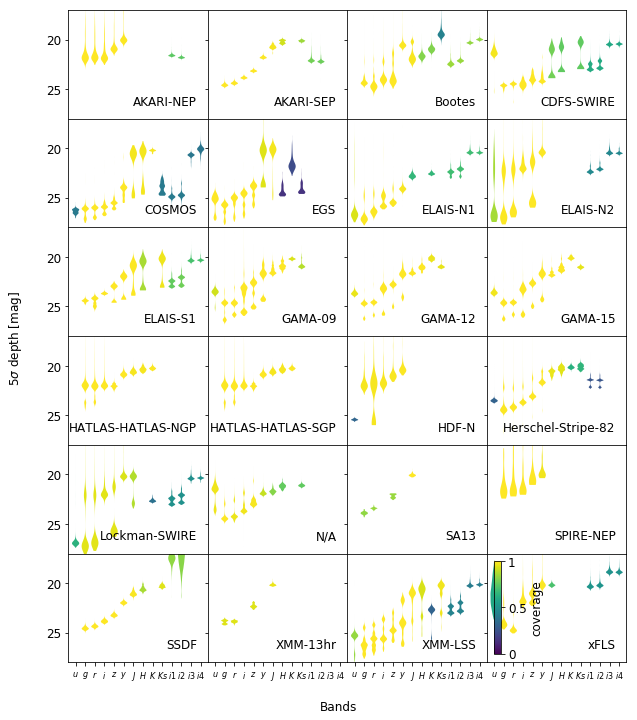

In [114]:
dim = [4,6]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
plt.rcParams.update({'font.size': 12})
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
scalmap = mpl.cm.ScalarMappable( cmap=cmap, norm=norm)

for n, f in enumerate(np.unique(coverage['field'])):
        
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    
    #axes[x,y].scatter( np.arange(20), np.arange(20))
    #axes[x,y].legend()
    
    
    #####MAKE FIELD DATA#####
    data_field = [ depths_sample_field(band, f)[0] for band in bands ]
    areas_field = [ depths_sample_field(band, f)[1] for band in bands ]
    data_field_mag = [flux_to_mag(10**d)[0] for d in data_field]
    
    
    colors = scalmap.to_rgba(areas_field)   # The color is the angle
    colors[:, 3] = 1

   

    def set_axis_style(ax, labels):
        axes[x,y].get_xaxis().set_tick_params(direction='out')
        axes[x,y].xaxis.set_ticks_position('bottom')
        axes[x,y].tick_params(axis='x', labelsize=8)
        axes[x,y].set_xticks(np.arange(1, len(labels) + 1))
        axes[x,y].set_xticklabels(labels)
        axes[x,y].set_xlim(0.25, len(labels) + 0.75)
        #axes[x,y].set_xlabel('band')
        #axes[x,y].set_ylabel('5$\sigma$ depth [mag]')
    #ax.violinplot(np.array(coverage['ferr_ap_{}_mean_min'.format('g') ] ) )
    #ax.set_title('Custom violinplot 1', fontsize=fs)

    #axes[x,y].set_ylabel('log10( 5$\sigma$ Depths  [Jy] )')
    set_axis_style(axes[x,y], ['$' + band + '$' for band in bands])
    axes[x,y].set_ylim(28, 17)



    parts = axes[x,y].violinplot(data_field_mag, widths=0.75, showmeans=False, showmedians=False,
            showextrema=False)
    
    
    #This is just to add the field name
    axes[x,y].scatter([-99],[-99], 
                      label=f.replace('SGP', 'HATLAS-SGP').replace('NGP', 'HATLAS-NGP'), 
                      c='w', s=0.0001)
    axes[x,y].legend(frameon=False, loc=4)

    for n, part in enumerate(parts['bodies']):
        part.set_facecolor(colors[n])
        part.set_alpha(1)

#cax, _ = mpl.colorbar.make_axes(axes[dim[1]-1,dim[0]-1], panchor=(-8.8, 10.6)) #5 3 depend on 4 x 6
#This bit moves the color bar
cax = inset_axes(axes[dim[1]-1,dim[0]-1],
                   width="5%",  # width = 5% of parent_bbox width
                   height="85%",  # height : 50%
                   loc=3,
                   bbox_to_anchor=(0.05, 0.08, 1, 1),
                   bbox_transform=axes[dim[1]-1,dim[0]-1].transAxes,
                   borderpad=0,
                   )

ticks = [0, 0.5, 1]
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = ticks)
cax.set_yticklabels(ticks)
cbar.set_label('coverage')
    
axes[dim[1]-1,dim[0]-1].tick_params(axis='x', labelsize=8)
#axes[dim[1]-1,dim[0]-1].set_xlabel('band')
    
fig.text(0.5, 0.07, 'Bands', ha='center')
fig.text(0.04, 0.5, '5$\sigma$ depth [mag]', va='center', rotation='vertical')

fig.set_size_inches(10, 12)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rc('axes', labelsize=12)
plt.savefig('./figs/fields_depths_comparison_grid.pdf', bbox_inches='tight')
plt.savefig('./figs/fields_depths_comparison_grid.png', bbox_inches='tight')

## Summarise the filters

In [115]:
for band in bands:
    specific_bands = [f for f in filters if f.split('_')[1] == band.lower()]
    print(specific_bands)
    for specific_band in specific_bands:
        if 'ferr_ap_{}_mean'.format(specific_band) not in coverage.colnames:
            specific_bands.remove(specific_band)
    #print(specific_bands)

['omegacam_u', 'mmt_u', 'bessell_u', 'lbc_u', 'wfi_u', 'megacam_u', 'mosaic_u', 'wfc_u', 'sdss_u']
['mmt_g', 'omegacam_g', 'suprime_g', 'megacam_g', 'wfc_g', 'gpc1_g', 'decam_g', '90prime_g', 'sdss_g']
['omegacam_r', 'mmt_r', 'cfht12k_r', 'megacam_r', 'wfi_r', 'suprime_r', 'mosaic_r', 'bessell_r', 'wfc_r', 'gpc1_r', 'decam_r', 'sdss_r', '90prime_r']
['sdss_i', 'decam_i', 'gpc1_i', 'wfc_i', 'bessell_i', 'mosaic_i', 'megacam_i', 'wfi_i', 'suprime_i', 'cfht12k_i', 'mmt_i', 'omegacam_i']
['decam_z', '90prime_z', 'sdss_z', 'wfc_z', 'gpc1_z', 'suprime_z', 'megacam_z', 'vista_z', 'mosaic_z', 'omegacam_z', 'mmt_z']
['decam_y', 'ukidss_y', 'gpc1_y', 'suprime_y', 'megacam_y', 'vista_y', 'lbc_y', 'wircam_y']
['omega2000_j', 'ukidss_j', 'vista_j', 'newfirm_j', 'wircs_j', 'wircam_j']
['ukidss_h', 'vista_h', 'newfirm_h', 'wircam_h']
['isaac_k', 'moircs_k', 'ukidss_k', 'newfirm_k', 'wircs_k', 'hawki_k']
['wircam_ks', 'vista_ks', 'moircs_ks', 'omega2000_ks', 'tifkam_ks']
['irac_i1']
['irac_i2']
['irac

In [116]:
filter_info = Table.read(herschelhelp_python_loc + 'documentation/filters.csv')

In [117]:
has_broad_typical = np.full(len(filter_info), False)
for band in bands:
    has_broad_typical |= filter_info['filter'] == band
    
filter_info[has_broad_typical]

﻿filter_file,telescope,camera,filter,surveys,description,wavelength_region,ucd
str17,str83,str83,str6,int64,int64,str3,str12
90prime_g.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),g,--,--,opt,B
90prime_r.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),r,--,--,opt,R
90prime_z.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),z,--,--,opt,I
bessell_i.xml,Standardised telescope response (telescope uknown),Standard camera response (camera unknown),i,--,--,opt,I
bessell_r.xml,Standardised telescope response (telescope uknown),Standard camera response (camera unknown),r,--,--,opt,R
bessell_u.xml,Standardised telescope response (telescope uknown),Standard camera response (camera unknown),u,--,--,opt,U
cfht12k_i.xml,Canada France Hawaii Telescope (CFHT),The CFH12K prime focus 12K camera,i,--,--,opt,I
cfht12k_r.xml,Canada France Hawaii Telescope (CFHT),The CFH12K prime focus 12K camera,r,--,--,opt,R
decam_g.xml,Blanco,The Dark Energy Camera (DECam),g,--,--,opt,B


In [118]:
has_optical = np.full(len(filter_info), False)
optical_bands = ['u', 'g', 'r', 'i', 'z', 'y']
has_near_infrared = np.full(len(filter_info), False)
near_infrared_bands = ['J', 'H', 'K', 'Ks']

for band in bands:
    if band in optical_bands:
        has_optical |= filter_info['filter'] == band
    if band in near_infrared_bands:
        has_near_infrared |= filter_info['filter'] == band

In [119]:
def get_bands(camera):
    band_list = []
    for b in filter_info['filter'][filter_info['camera'] == camera]:
        #print(b)
        band_list.append( b)
    band_list_ordered_string = ''
    for band in bands:
        if band in band_list:
            band_list_ordered_string += band
    
    return '$' + band_list_ordered_string + '$'



print(get_bands('HyperSuprimeCam'))

$grizy$


In [120]:


optical_sentence = ''
for camera in np.unique(filter_info['camera'][has_optical]):
    if camera == 'Standard camera response (camera unknown)':
        continue
    row = filter_info[filter_info['camera'] == camera][0] 
    optical_sentence += 'From {} on {} we have the optical bands {}. '.format(row['camera'].replace('The', 'the'), 
                                                             row['telescope'].replace('The', 'the'),
                                                             get_bands(camera))
    
print(optical_sentence)

From HyperSuprimeCam on the Subaru telescope we have the optical bands $grizy$. From MegaCam on the Multiple Mirror Telescope (MMT) Observatory we have the optical bands $ugriz$. From MegaPrime/MegaCam on Canada France Hawaii Telescope (CFHT) we have the optical bands $ugrizy$. From Mosaic-3 Wide Field Imager on the Kitt Peak National Observatory we have the optical bands $uriz$. From OmegaCAM on the Very Large Telescope (VLT) Survey Telescope (VST) at Paranal we have the optical bands $ugriz$. From the 90-inch prime focus camera (90prime) on the Bok Telescope we have the optical bands $grz$. From the CFH12K prime focus 12K camera on Canada France Hawaii Telescope (CFHT) we have the optical bands $ri$. From the Dark Energy Camera (DECam) on Blanco we have the optical bands $grizy$. From the Pan-STARRS Gigapixel Camera on the Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) we have the optical bands $grizy$. From the Sloan Digital Sky Survey (SDSS) standard camera on th

In [121]:
near_infrared_sentence = ''
for camera in np.unique(filter_info['camera'][has_near_infrared]):
    if camera == 'Standard camera response (camera unknown)':
        continue
    row = filter_info[filter_info['camera'] == camera][0] 
    near_infrared_sentence += 'From {} on {} we have the optical bands {}. '.format(row['camera'].replace('The', 'the'), 
                                                             row['telescope'].replace('The', 'the'),
                                                             get_bands(camera))
    
print(near_infrared_sentence)

From National Optical Astronomy Observatory (NOAO) Extremely Wide-Field Imager (NEWFIRM) on National Optical Astronomy Observatory (NOAO) Gemini Observatory we have the optical bands $JHK$. From the High Acuity Wide field K-band Imager (HAWK-I) on the Very Large Telescope (VLT) at Paranal we have the optical bands $K$. From the Infrared Spectrometer And Array Camera (ISAAC) on the Very Large Telescope (VLT) at Paranal we have the optical bands $Ks$. From the Infrared Wide-Field Camera OMEGA2000 on the 3.5m telescope at Calar Alto we have the optical bands $JKs$. From the Instrument Formerly Known as Mosaic (TIFKAM) on the Michigan Dartmouth MIT (MDM) Observatory we have the optical bands $Ks$. From the Multi Object Infrared Camera and Spectrograph (MOIRCS) on the Subaru telescope we have the optical bands $KKs$. From the VISTA InfraRed CAMera (VIRCAM) on the 4.1m Visible and Infrared Survey Telescope for Astronomy (VISTA) we have the optical bands $JHKs$. From the Wide Field Camera (WF

## Count the number of flagged objects

For each band lets count the number of objects that have a flag

# Make cumulative 1 d depths for MIPS, PACS, SPIRE

In [235]:
np.array(en1_depths['ferr_mips_24_mean'])[~np.isnan(en1_depths['ferr_mips_24_mean'])]

array([15.0531  , 15.0531  , 15.0531  , ..., 44.835475, 44.835475,
       44.835475])

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


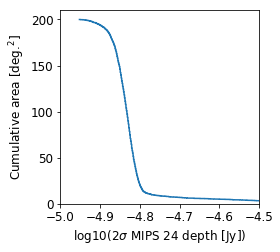

In [257]:


fig, ax = plt.subplots()

#good = np.log10(np.array(g_table['ferr_g_min'])*1.e-6) > -20
#good &= np.log10(np.array(g_table['ferr_g_min'])*1.e-6) <20

mips_pix_mag_depths = np.array(np.log10(en1_depths['ferr_mips_24_mean']*1.e-6 ))
cells, fluxes = np.histogram(mips_pix_mag_depths[~np.isnan(mips_pix_mag_depths)], bins=1000)
cells =np.flip(cells)
fluxes = np.flip(fluxes)

ax.plot(fluxes[1:],
         np.cumsum(cells)*200./cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('log10(2$\sigma$ MIPS 24 depth [Jy]) ')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([-5,-4.5])
ax.set_ylim([0,210])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])



plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/mips_cumulative_area_depth.pdf', bbox_inches='tight')
plt.savefig('./figs/mips_cumulative_area_depth.png', bbox_inches='tight')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


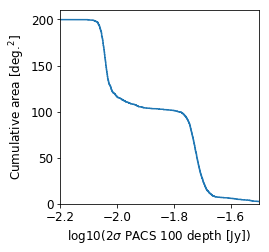

In [258]:


fig, ax = plt.subplots()

#good = np.log10(np.array(g_table['ferr_g_min'])*1.e-6) > -20
#good &= np.log10(np.array(g_table['ferr_g_min'])*1.e-6) <20

pacs_pix_mag_depths = np.array(np.log10(en1_depths['ferr_pacs_green_mean']*1.e-6 ))
cells, fluxes = np.histogram(pacs_pix_mag_depths[~np.isnan(pacs_pix_mag_depths)], bins=1000)
cells =np.flip(cells)
fluxes = np.flip(fluxes)

ax.plot(fluxes[1:],
         np.cumsum(cells)*200./cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('log10(2$\sigma$ PACS 100 depth [Jy]) ')
ax.set_ylabel('Cumulative area [deg.$^2$]')
ax.set_xlim([-2.2,-1.5])
ax.set_ylim([0,210])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])



plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/pacs_cumulative_area_depth.pdf', bbox_inches='tight')
plt.savefig('./figs/pacs_cumulative_area_depth.png', bbox_inches='tight')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


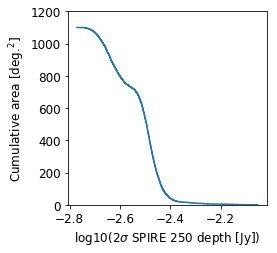

In [259]:


fig, ax = plt.subplots()

#good = np.log10(np.array(g_table['ferr_g_min'])*1.e-6) > -20
#good &= np.log10(np.array(g_table['ferr_g_min'])*1.e-6) <20

spire_pix_mag_depths = np.array(np.log10(en1_depths['ferr_spire_250_mean']*1.e-6 ))
cells, fluxes = np.histogram(spire_pix_mag_depths[~np.isnan(spire_pix_mag_depths)], bins=1000)
cells =np.flip(cells)
fluxes = np.flip(fluxes)

ax.plot(fluxes[1:],
         np.cumsum(cells)*1100./cells.sum() ,
        drawstyle='steps')

ax.set_xlabel('log10(2$\sigma$ SPIRE 250 depth [Jy])')
ax.set_ylabel('Cumulative area [deg.$^2$]')
#ax.set_xlim([-2.2,-1.5])
ax.set_ylim([0,1200])
#y_vals = ax.get_yticks()
#ax.set_yticklabels([n for n in y_vals])



plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/spire_cumulative_area_depth.pdf', bbox_inches='tight')
plt.savefig('./figs/spire_cumulative_area_depth.png', bbox_inches='tight')

# 2d depth plots

Make a cumulative 2d area that is at least as deep.

In [6]:
en1_d = Table.read('../../../dmu32/dmu32_ELAIS-N1/data/depths_elais-n1_20171016.fits')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


(array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,   64.,   64.,
           64.,  192.,  128.,  256.,  128.,  192.,   64.,  320.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   64.,   64.,  192.,
          256.,  512.,  768.,  896.,  320.,  960.,  640.,  320.,  192.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   64.,  192.,  384.,
          448.,  704.,  896., 1344.,  512.,  576.,  448.,  448.,  320.,
          128.,   64.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   64.,  256.,  128.,
          768.,  960., 1152., 1280., 1344.,  832.,  832.,  320.,  192.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,   64.,    0.,    0.,   64.,  128.,  320.,  256.,
          384.,  576.,  640.,  576.,  448.,  640.,  512.,  320.,  256.,
           64.,    0.,   64.,    0.,    0., 

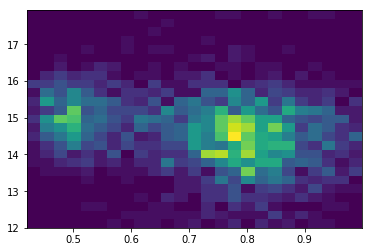

In [7]:
fig, ax = plt.subplots()
good = ~np.isnan(en1_d['ferr_ap_irac_i1_mean']) & ~np.isnan(en1_d['ferr_mips_24_mean'])
good &= en1_d['ferr_ap_irac_i1_mean'] < 1.
good &= en1_d['ferr_mips_24_mean'] > 12.
good &= en1_d['ferr_mips_24_mean'] < 18.
ax.hist2d(en1_d['ferr_ap_irac_i1_mean'][good],en1_d['ferr_mips_24_mean'][good],  bins=25)


In [8]:
good &= en1_d['ferr_ap_irac_i1_mean'] < 1.
good &= en1_d['ferr_mips_24_mean'] > 12.
good &= en1_d['ferr_mips_24_mean'] < 18.

hist = np.histogram2d(en1_d['ferr_ap_irac_i1_mean'][good],en1_d['ferr_mips_24_mean'][good],  bins=25)
hist

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


(array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,   64.,   64.,
           64.,  192.,  128.,  256.,  128.,  192.,   64.,  320.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   64.,   64.,  192.,
          256.,  512.,  768.,  896.,  320.,  960.,  640.,  320.,  192.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   64.,  192.,  384.,
          448.,  704.,  896., 1344.,  512.,  576.,  448.,  448.,  320.,
          128.,   64.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,   64.,  256.,  128.,
          768.,  960., 1152., 1280., 1344.,  832.,  832.,  320.,  192.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,   64.,    0.,    0.,   64.,  128.,  320.,  256.,
          384.,  576.,  640.,  576.,  448.,  640.,  512.,  320.,  256.,
           64.,    0.,   64.,    0.,    0., 

In [37]:
vals

array([[9.36992671e+00, 1.86873976e-01, 2.62279264e-02, 1.96709448e-02,
        9.83547240e-03, 9.83547240e-03, 3.27849080e-03, 3.27849080e-03,
        3.27849080e-03, 3.27849080e-03],
       [4.11450596e+00, 1.31139632e-01, 2.29494356e-02, 1.63924540e-02,
        6.55698160e-03, 6.55698160e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.57343436e-01, 5.90128344e-02, 1.63924540e-02, 1.31139632e-02,
        6.55698160e-03, 6.55698160e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.96709448e-01, 1.96709448e-02, 6.55698160e-03, 6.55698160e-03,
        3.27849080e-03, 3.27849080e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [4.58988712e-02, 6.55698160e-03, 3.27849080e-03, 3.27849080e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.96709448e-02, 3.27849080e-03, 0.00000000e+00, 0.00000000e+00,
   

In [26]:
from pymoc import MOC
t_moc = MOC(13, [en1_d['hp_idx_O_13'][0] ])
t_moc.area_sq_deg

5.122641877509563e-05

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


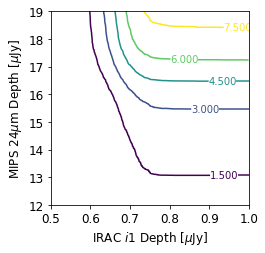

In [160]:
band1 = ['ferr_ap_irac_i1_mean',0.,1.]
band2 = ['ferr_mips_24_mean',0.,20. ]
#good = ~np.isnan(en1_d[band1[0]] ) & ~np.isnan(en1_d[band2[0]] )
good = en1_d[band1[0]] > band1[1]
good &= en1_d[band1[0]] < band1[2]
good &= en1_d[band2[0]] > band2[1]
good &= en1_d[band2[0]] < band2[2]

hist = np.histogram2d(en1_d[band1[0]][good],en1_d[band2[0]][good],  bins=1000)
vals = hist[0].copy() * t_moc.area_sq_deg
#vals = np.flip(np.cumsum(np.cumsum(np.flip(vals), axis=0),axis=1))
vals = np.cumsum(np.cumsum(vals, axis=0),axis=1)
fig, ax = plt.subplots()


#im = imshow(np.flip(Z, axis=0),cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#cbar = fig.colorbar(im) # adding the colobar on the right
#cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

CS = ax.contour(hist[1][:-1] + (hist[1][1]-hist[1][0])/2, 
                hist[2][:-1] + (hist[2][1]-hist[2][0])/2, 
                vals
                #,[levels]
               )
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim([0.5, 1.])
ax.set_ylim([12., 19.])

ax.set_xlabel('IRAC $i1$ Depth [$\mu$Jy]')
ax.set_ylabel('MIPS 24$\mu$m Depth [$\mu$Jy]')


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/2d_i1_mips_depth.pdf', bbox_inches='tight')
plt.savefig('./figs/2d_i1_mips_depth.png', bbox_inches='tight')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


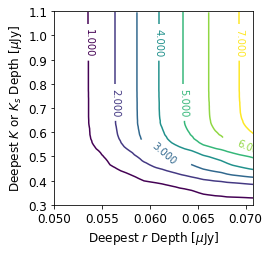

In [159]:
band1 = ['ferr_ap_r_mean',0.,1.2]
band2 = ['ferr_ap_k_mean',0.,1.1 ]
#good = ~np.isnan(en1_d[band1[0]] ) & ~np.isnan(en1_d[band2[0]] )
good = en1_d[band1[0]] > band1[1]
good &= en1_d[band1[0]] < band1[2]
good &= en1_d[band2[0]] > band2[1]
good &= en1_d[band2[0]] < band2[2]

hist = np.histogram2d(en1_d[band1[0]][good],en1_d[band2[0]][good],  bins=100)
vals = hist[0].copy() * t_moc.area_sq_deg
#vals = np.flip(np.cumsum(np.cumsum(np.flip(vals), axis=0),axis=1))
vals = np.cumsum(np.cumsum(vals, axis=0),axis=1)
fig, ax = plt.subplots()


#im = imshow(np.flip(Z, axis=0),cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#cbar = fig.colorbar(im) # adding the colobar on the right
#cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

CS = ax.contour(hist[1][:-1] + (hist[1][1]-hist[1][0])/2, 
                hist[2][:-1] + (hist[2][1]-hist[2][0])/2, 
                vals
                #,[levels]
               )
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim([0.05, .07075])
ax.set_ylim([0.3, 1.1])

ax.set_xlabel('Deepest $r$ Depth [$\mu$Jy]')
ax.set_ylabel('Deepest $K$ or $K_s$ Depth [$\mu$Jy]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/2d_r_k_depth.pdf', bbox_inches='tight')
plt.savefig('./figs/2d_r_k_depth.png', bbox_inches='tight')

In [88]:
np.sum(vals)

0.0

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


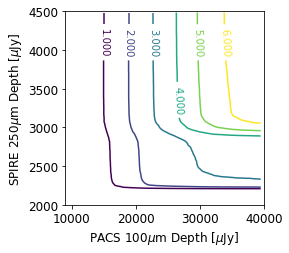

In [158]:
band1 = ['ferr_pacs_green_mean',0.,40000.2]
band2 = ['ferr_spire_350_mean',0.,4500.1 ]
#good = ~np.isnan(en1_d[band1[0]] ) & ~np.isnan(en1_d[band2[0]] )
good = en1_d[band1[0]] > band1[1]
good &= en1_d[band1[0]] < band1[2]
good &= en1_d[band2[0]] > band2[1]
good &= en1_d[band2[0]] < band2[2]

hist = np.histogram2d(en1_d[band1[0]][good],en1_d[band2[0]][good],  bins=100)
vals = hist[0].copy() * t_moc.area_sq_deg
#vals = np.flip(np.cumsum(np.cumsum(np.flip(vals), axis=0),axis=1))
vals = np.cumsum(np.cumsum(vals, axis=0),axis=1)
fig, ax = plt.subplots()


#im = imshow(np.flip(Z, axis=0),cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#cbar = fig.colorbar(im) # adding the colobar on the right
#cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

CS = ax.contour(hist[1][:-1] + (hist[1][1]-hist[1][0])/2, 
                hist[2][:-1] + (hist[2][1]-hist[2][0])/2, 
                vals
                #,[levels]
               )
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim([9000., 40000.])
ax.set_ylim([2000., 4500.])

ax.set_xlabel('PACS 100$\mu$m Depth [$\mu$Jy]')
ax.set_ylabel('SPIRE 250$\mu$m Depth [$\mu$Jy]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/2d_pacs_spire_depth.pdf', bbox_inches='tight')
plt.savefig('./figs/2d_pacs_spire_depth.png', bbox_inches='tight')